In [1]:
# Install the required libraries
!pip install prophet
!pip install seaborn

In [ ]:
# Dependencies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns 
import re

In [12]:
#Read data into the notebook
aicompany_profits_df = pd.read_csv('./data_sets/AI_AmericanCompaniesProfits.csv').dropna()
linkedin_postings_df = pd.read_csv('./data_sets/postings.csv').dropna()
machine_learning_jobs_df = pd.read_json('./data_sets/job_data.json', lines=True)

# Normalize, clean, massage, and combine data for ease of processing

# Cast all job skills to lower case strings to standardize string matching later
linkedin_postings_df['job_skills'] = linkedin_postings_df['job_skills'].apply(lambda item: item.lower().split(', '))

In [13]:
print(aicompany_profits_df.head(5))

              Company Name              Sector  Profits in USD  \
0                3Com Corp          Technology          388550   
1               3M Company       Manufacturing          295319   
2        A.G. Edwards Inc.  Financial Services          956265   
3      Abbott Laboratories          Healthcare          945432   
4  Abercrombie & Fitch Co.              Retail          958207   

                                        AI Benefits  
0     Improved product functionality and efficiency  
1         Optimized operations and quality control   
2  Fraud detection and personalized recommendations  
3       Enhanced diagnostics and precision medicine  
4     Demand forecasting and inventory optimization  


In [14]:
# Get all job listings with an AI related keyword  listed as a skill requirement 
terms_to_match = ['machine learning', 'artificial intelligence', 'pytorch', 'langchain', 'ai', 'tensorflow', 'deep learning', 'neural network', 
               'natural language processing', 'nlp', 'computer vision', 'large language models', 'chatbot', 'ai chatbot', 'llm', 'llms', 'generative ai', 'generative models', 'genai', 'bert', 'spacy', 'nltk', 'keras', 'gpt', 'chatgpt', 'prompt development', 'prompt engineering']
linkedin_postings_df['job_skills'] = linkedin_postings_df['job_skills']
linkedin_postings_df['has_ai'] = linkedin_postings_df['job_skills'].apply(
    lambda skills: any(term in skills for term in terms_to_match)
)
#Separate the groupings into two new dataframes
ai_roles = linkedin_postings_df.loc[linkedin_postings_df['has_ai'] == True]
# Job listings without AI keywords will be classified as "general" roles
general_roles = linkedin_postings_df.loc[linkedin_postings_df['has_ai'] == False] 

***Introduction*** 
The goal of this exploratory data analysis is to characterize and investigate the growth of machine learning as a job skill. We are interested in looking at this topic along a number angles. TBC....
Our dataset includes 9367 job postings takend from linkedin for the 2023 calendar year. 

# US Census Predictions

Based on the available data from the US Census API for the years of 2012 to 2022, what relationships can be found between jobs that would most likely use AI/ML skills (referred to as tech-related jobs, as the closest available data applied to three sectors with descriptions closest to the needs of this project) and other national trends? Most particularly, in the frame of average national percentages, what correlations can be drawn between tech-related jobs and education levels and unemployment rates?

### Additional assets required

Importing Prophet and the previously compiled data from the US Census API ACS 5-Year rolling estimates (see `census_API_request.ipynb`)

In [15]:
# Additional dependencies
from prophet import Prophet

In [16]:
# Additional data reading
combined_acs5 = pd.read_csv('./data_sets/combined_acs5_12-22_data.csv')

### Preparing the Data

Once imported, the data from the US Census API needs to be manipulated for EDA purposes. This is accomplished by slicing necessary columns from the source DataFrame and calculating other potentially necessary fields from there.

The following fields are directly imported from the source file;\
\
`Name`\
`Year`\
`population`\
`employment_employed`\
`employment_unemployed`\
`education_none`\
`education_high_school`\
`education_ged`\
`education_associates`\
`education_bachelors`\
`education_masters`\
`education_professional`\
`education_doctorate`\
\
The following fields are calculated based off the variable population against the state population;\
\
`Percent Employed`\
`Percent Unemployed`\
`Total Pop in Tech Fields`\
`Percent in Tech Fields`\
`Percent No Education`\
`Percent High School`\
`Percent GED`\
`Percent Associates`\
`Percent Bachelors`\
`Percent Masters`\
`Percent Professional Education`\
`Percent Doctorate`\
\
**Note:** While not all columns were used in the final analysis, each played a role during the EDA process.

In [17]:
# Creating a working DF for population calculations
for row in combined_acs5:
    # Slicing columns from the UC Sensus data source DataFrame
    pop_data = combined_acs5.loc[:,[
                'Name',
                'Year',
                'population',
                'employment_employed',
                'employment_unemployed',
                'education_none',
                'education_high_school',
                'education_ged',
                'education_associates',
                'education_bachelors',
                'education_masters',
                'education_professional',
                'education_doctorate'
                ]]
    # Calculating the percentage of employed and unemployed populations
    pop_data['Percent Employed'] = (combined_acs5.loc[:,'employment_employed']/combined_acs5.loc[:,'population']) * 100
    pop_data['Percent Unemployed'] = (combined_acs5.loc[:,'employment_unemployed']/combined_acs5.loc[:,'population']) * 100
    # Calculating the total and percentage of populations working in tech-related fields
    pop_data['Total Pop in Tech Fields'] = (
                                            combined_acs5.loc[:,'employment_male_business_and_financial_operations_occupations'] +
                                            combined_acs5.loc[:,'employment_male_computer_engineering_and_science_occupations'] +
                                            combined_acs5.loc[:,'employment_male_computer_and_mathematical_occupations'] +
                                            combined_acs5.loc[:,'employment_female_business_and_financial_operations_occupations'] +
                                            combined_acs5.loc[:,'employment_female_computer_engineering_and_science_occupations'] +
                                            combined_acs5.loc[:,'employment_female_computer_and_mathematical_occupations']
                                        )
    pop_data['Percent in Tech Fields'] = (pop_data.loc[:,'Total Pop in Tech Fields']/combined_acs5.loc[:,'population']) * 100
    # Calculating the percentage of populations with a given education level
    pop_data['Percent No Education'] = (combined_acs5.loc[:,'education_none']/combined_acs5.loc[:,'population']) * 100
    pop_data['Percent High School'] = (combined_acs5.loc[:,'education_high_school']/combined_acs5.loc[:,'population']) * 100
    pop_data['Percent GED'] = (combined_acs5.loc[:,'education_ged']/combined_acs5.loc[:,'population']) * 100
    pop_data['Percent Associates'] = (combined_acs5.loc[:,'education_associates']/combined_acs5.loc[:,'population']) * 100
    pop_data['Percent Bachelors'] = (combined_acs5.loc[:,'education_bachelors']/combined_acs5.loc[:,'population']) * 100
    pop_data['Percent Masters'] = (combined_acs5.loc[:,'education_masters']/combined_acs5.loc[:,'population']) * 100
    pop_data['Percent Professional Education'] = (combined_acs5.loc[:,'education_professional']/combined_acs5.loc[:,'population']) * 100
    pop_data['Percent Doctorate'] = (combined_acs5.loc[:,'education_doctorate']/combined_acs5.loc[:,'population']) * 100

# Confirming working DF populated correctly
display(pop_data.head(2))
display(pop_data.tail(2))

,Name,Year,population,employment_employed,employment_unemployed,education_none,education_high_school,education_ged,education_associates,education_bachelors,...,Total Pop in Tech Fields,Percent in Tech Fields,Percent No Education,Percent High School,Percent GED,Percent Associates,Percent Bachelors,Percent Masters,Percent Professional Education,Percent Doctorate
0,Alabama,2012,4777326.0,2017887.0,230778.0,40659.0,818162.0,173244.0,227301.0,448117.0,...,200378.0,4.194355,0.851083,17.125940,3.626380,4.757913,9.380080,3.829757,0.934874,0.612518
1,Alaska,2012,711139.0,341115.0,31369.0,2674.0,98765.0,22507.0,35312.0,79441.0,...,37544.0,5.279418,0.376017,13.888283,3.164923,4.965555,11.170953,4.318143,1.054224,0.748377


,Name,Year,population,employment_employed,employment_unemployed,education_none,education_high_school,education_ged,education_associates,education_bachelors,...,Total Pop in Tech Fields,Percent in Tech Fields,Percent No Education,Percent High School,Percent GED,Percent Associates,Percent Bachelors,Percent Masters,Percent Professional Education,Percent Doctorate
570,Wyoming,2022,577929.0,287895.0,11456.0,2890.0,88797.0,21480.0,46082.0,71313.0,...,27321.0,4.727397,0.500061,15.364690,3.716720,7.973644,12.339405,5.373151,1.051513,0.889037
571,Puerto Rico,2022,3272382.0,1081330.0,165697.0,51914.0,617845.0,54436.0,271432.0,482139.0,...,105007.0,3.208886,1.586428,18.880589,1.663498,8.294631,14.733579,4.115443,0.939621,0.943991


As `Prophet` requires Datetime format for its predictions, the `Year` column needs to be assigned more details than available from the Census API data. Since the data represents a rolling 5-year average for the given year, ultimately the more granular date details (month, day, and timestamp) are irrelivent so long as they are consistent. To that end, the value for December 30th, just before noon, is assigned to all rows for their given years.

In [18]:
# Converting `Year` to Datetime format for future use with Prophet
# (`YYYY-12-30 11:59:59` chosen for Datetime format since data only came with `YYYY`)
pop_data['Year'] = pd.to_datetime({'year': pop_data['Year'],
                                   'month': 12,
                                   'day': 30,
                                   'hour': 11,
                                   'minute': 59,
                                   'second': 59
                                    })

# Verifying applied correctly
# Confirming working DF populated correctly
display(pop_data.head(2))
display(pop_data.tail(2))

,Name,Year,population,employment_employed,employment_unemployed,education_none,education_high_school,education_ged,education_associates,education_bachelors,...,Total Pop in Tech Fields,Percent in Tech Fields,Percent No Education,Percent High School,Percent GED,Percent Associates,Percent Bachelors,Percent Masters,Percent Professional Education,Percent Doctorate
0,Alabama,2012-12-30 11:59:59,4777326.0,2017887.0,230778.0,40659.0,818162.0,173244.0,227301.0,448117.0,...,200378.0,4.194355,0.851083,17.125940,3.626380,4.757913,9.380080,3.829757,0.934874,0.612518
1,Alaska,2012-12-30 11:59:59,711139.0,341115.0,31369.0,2674.0,98765.0,22507.0,35312.0,79441.0,...,37544.0,5.279418,0.376017,13.888283,3.164923,4.965555,11.170953,4.318143,1.054224,0.748377


,Name,Year,population,employment_employed,employment_unemployed,education_none,education_high_school,education_ged,education_associates,education_bachelors,...,Total Pop in Tech Fields,Percent in Tech Fields,Percent No Education,Percent High School,Percent GED,Percent Associates,Percent Bachelors,Percent Masters,Percent Professional Education,Percent Doctorate
570,Wyoming,2022-12-30 11:59:59,577929.0,287895.0,11456.0,2890.0,88797.0,21480.0,46082.0,71313.0,...,27321.0,4.727397,0.500061,15.364690,3.716720,7.973644,12.339405,5.373151,1.051513,0.889037
571,Puerto Rico,2022-12-30 11:59:59,3272382.0,1081330.0,165697.0,51914.0,617845.0,54436.0,271432.0,482139.0,...,105007.0,3.208886,1.586428,18.880589,1.663498,8.294631,14.733579,4.115443,0.939621,0.943991


### Initial Data Exploration

Examining values and data types to prepare for more direct analysis and in preparation for further processing.

In [19]:
# Confirming unique States
pop_data['Name'].value_counts()

Name
Alabama                 11
Alaska                  11
Nevada                  11
New Hampshire           11
New Jersey              11
New Mexico              11
New York                11
North Carolina          11
North Dakota            11
Ohio                    11
Oklahoma                11
Oregon                  11
Pennsylvania            11
Rhode Island            11
South Carolina          11
South Dakota            11
Tennessee               11
Texas                   11
Vermont                 11
Utah                    11
Virginia                11
Washington              11
West Virginia           11
Wisconsin               11
Wyoming                 11
Nebraska                11
Montana                 11
Missouri                11
Hawaii                  11
Arizona                 11
Arkansas                11
California              11
Colorado                11
Delaware                11
District of Columbia    11
Connecticut             11
Florida                

In [20]:
# Confirming data types for `pop_data`
pop_data.dtypes

Name                                      object
Year                              datetime64[ns]
population                               float64
employment_employed                      float64
employment_unemployed                    float64
education_none                           float64
education_high_school                    float64
education_ged                            float64
education_associates                     float64
education_bachelors                      float64
education_masters                        float64
education_professional                   float64
education_doctorate                      float64
Percent Employed                         float64
Percent Unemployed                       float64
Total Pop in Tech Fields                 float64
Percent in Tech Fields                   float64
Percent No Education                     float64
Percent High School                      float64
Percent GED                              float64
Percent Associates  

### Slicing Data

Preparing slices of data for use with Prophet. At this stage, it is unclear on what the final predictions will be made, so slices for each relevant component of the data are declared.

In [21]:
# Slicing data into working DFs for future use with Prophet
# For total population
slice_pop = pop_data[[
                      'Name',
                      'Year',
                      'population'
                    ]]

# For total employed population
slice_emp_tot = pop_data[[
                          'Name',
                          'Year',
                          'employment_employed'
                        ]]

# For percentage of employed population
slice_emp_pct = pop_data[[
                          'Name',
                          'Year',
                          'Percent Employed'
                        ]]

# For total unemployed population
slice_unemp_tot = pop_data[[
                            'Name',
                            'Year',
                            'employment_unemployed'
                          ]]

# For percentage of unemployed population
slice_unemp_pct = pop_data[[
                            'Name',
                            'Year',
                            'Percent Unemployed'
                          ]]

# For total with no education
slice_edu_non_tot = pop_data[[
                              'Name',
                              'Year',
                              'education_none'
                            ]]

# For percentage with no education
slice_edu_non_pct = pop_data[[
                              'Name',
                              'Year',
                              'Percent No Education'
                            ]]

# For total with high school diploma
slice_edu_hs_tot = pop_data[[
                             'Name',
                             'Year',
                             'education_high_school'
                           ]]

# For percentage with high school diploma
slice_edu_hs_pct = pop_data[[
                             'Name',
                             'Year',
                             'Percent High School'
                           ]]

# For total with GED
slice_edu_ged_tot = pop_data[[
                              'Name',
                              'Year',
                              'education_ged'
                            ]]

# For percentage with GED
slice_edu_ged_pct = pop_data[[
                              'Name',
                              'Year',
                              'Percent GED'
                            ]]

# For total with associates degree
slice_edu_asc_tot = pop_data[[
                              'Name',
                              'Year',
                              'education_associates'
                            ]]

# For percentage with associates degree
slice_edu_asc_pct = pop_data[[
                              'Name',
                              'Year',
                              'Percent Associates'
                            ]]

# For total with bachelors degree
slice_edu_bch_tot = pop_data[[
                              'Name',
                              'Year',
                              'education_bachelors'
                            ]]

# For percentage with bachelors degree
slice_edu_bch_pct = pop_data[[
                              'Name',
                              'Year',
                              'Percent Bachelors'
                            ]]

# For total with masters degree
slice_edu_mst_tot = pop_data[[
                              'Name',
                              'Year',
                              'education_masters'
                            ]]

# For percentage with masters degree
slice_edu_mst_pct = pop_data[[
                              'Name',
                              'Year',
                              'Percent Masters'
                            ]]

# For total with professional education
slice_edu_prf_tot = pop_data[[
                              'Name',
                              'Year',
                              'education_professional'
                            ]]

# For percentage with professional education 
slice_edu_prf_pct = pop_data[[
                              'Name',
                              'Year',
                              'Percent Professional Education'
                            ]]

# For total with doctorate
slice_edu_doc_tot = pop_data[[
                              'Name',
                              'Year',
                              'education_doctorate'
                            ]]

# For percentage with doctorate 
slice_edu_doc_pct = pop_data[[
                              'Name',
                              'Year',
                              'Percent Doctorate'
                            ]]

# For total working in tech-related fields
slice_tech_tot = pop_data[[
                           'Name',
                           'Year',
                           'Total Pop in Tech Fields'
                         ]]

# For percentage working in tech-related fields
slice_tech_pct = pop_data[[
                           'Name',
                           'Year',
                           'Percent in Tech Fields'
                         ]]

### National Trends

Applying slices to a National scale to explore trends and correlations. Since all states are represented in each given year, grouping by `Year` provides the national averages when aggregated by `.mean()`.

In [22]:
# Grouping data from slices for National analysis

# Grouping percentatge of unemployed population by year
national_unemp = slice_unemp_pct[['Year', 'Percent Unemployed']].groupby('Year').mean()

# Resetting the index for the grouped slice
national_unemp.reset_index(inplace=True)

# Renaming columns for use with Prophet
national_unemp.rename(columns={
                        'Year': 'ds',
                        'Percent Unemployed': 'y'
                    }, inplace=True)


# Grouping percentatge of population employed in tech-related fields
national_tech = slice_tech_pct[['Year', 'Percent in Tech Fields']].groupby('Year').mean()

# Resetting the index for the grouped slice
national_tech.reset_index(inplace=True)

# Renaming columns for use with Prophet
national_tech.rename(columns={
                        'Year': 'ds',
                        'Percent in Tech Fields': 'y'
                    }, inplace=True)


# Grouping percentatge of population with no education by year
national_edu_non = slice_edu_non_pct[['Year', 'Percent No Education']].groupby('Year').mean()

# Resetting the index for the grouped slice
national_edu_non.reset_index(inplace=True)

# Renaming columns for use with Prophet
national_edu_non.rename(columns={
                            'Year': 'ds',
                            'Percent No Education': 'y'
                        }, inplace=True)


# Grouping percentatge of population with a high school education by year
national_edu_hs = slice_edu_hs_pct[['Year', 'Percent High School']].groupby('Year').mean()

# Resetting the index for the grouped slice
national_edu_hs.reset_index(inplace=True)

# Renaming columns for use with Prophet
national_edu_hs.rename(columns={
                            'Year': 'ds',
                            'Percent High School': 'y'
                        }, inplace=True)


# Grouping percentatge of population with a GED by year
national_edu_ged = slice_edu_ged_pct[['Year', 'Percent GED']].groupby('Year').mean()

# Resetting the index for the grouped slice
national_edu_ged.reset_index(inplace=True)

# Renaming columns for use with Prophet
national_edu_ged.rename(columns={
                            'Year': 'ds',
                            'Percent GED': 'y'
                        }, inplace=True)


# Grouping percentatge of population with an associates degree by year
national_edu_asc = slice_edu_asc_pct[['Year', 'Percent Associates']].groupby('Year').mean()

# Resetting the index for the grouped slice
national_edu_asc.reset_index(inplace=True)

# Renaming columns for use with Prophet
national_edu_asc.rename(columns={
                            'Year': 'ds',
                            'Percent Associates': 'y'
                        }, inplace=True)


# Grouping percentatge of population with a bachelors degree by year
national_edu_bch = slice_edu_bch_pct[['Year', 'Percent Bachelors']].groupby('Year').mean()

# Resetting the index for the grouped slice
national_edu_bch.reset_index(inplace=True)

# Renaming columns for use with Prophet
national_edu_bch.rename(columns={
                            'Year': 'ds',
                            'Percent Bachelors': 'y'
                        }, inplace=True)


# Grouping percentatge of population with a professional education by year
national_edu_prf = slice_edu_prf_pct[['Year', 'Percent Professional Education']].groupby('Year').mean()

# Resetting the index for the grouped slice
national_edu_prf.reset_index(inplace=True)

# Renaming columns for use with Prophet
national_edu_prf.rename(columns={
                            'Year': 'ds',
                            'Percent Professional Education': 'y'
                        }, inplace=True)

### Exploring National Trends

Plotting out the 10-year trends on the available education levels begins to paint a picture, especially when framed by the trends in the percentage of the population working in tech-related fields.

**NOTE:** New slices are prepared as `Name` is unnecessary when data is grouped by `Year`.

<Axes: xlabel='Year'>

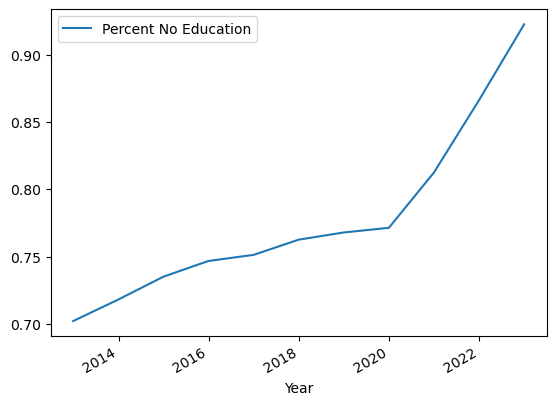

In [23]:
# Slicing for the percent of the population 
grph_no_edu = pop_data[[
                        'Year',
                        'Percent No Education'
                      ]]

# Grouping by `Year` for national averages
grph_no_edu = grph_no_edu.groupby('Year').mean()

# Quick plotting of data
grph_no_edu.plot()

The sudden increase in a percentage of the population not receiving a traditional education before even completing high school is likely a result of Covid. Many younger students were hit the hardest by the shift to remote learning, which might cause many families to pursue alternative forms of education for their children.

<Axes: xlabel='Year'>

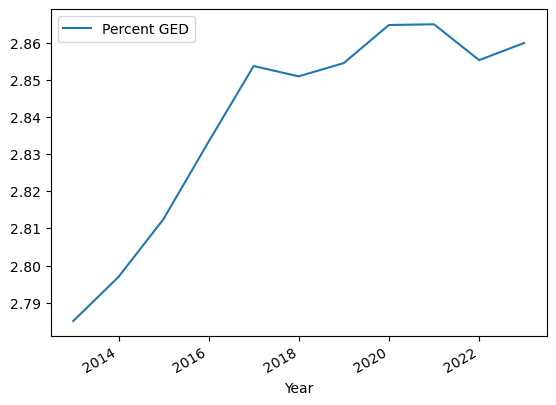

In [24]:
# Slicing for the percent of the population with a GED
grph_ge_edu = pop_data[[
                        'Year',
                        'Percent GED'
                      ]]

# Grouping by `Year` for national averages
grph_ge_edu = grph_ge_edu.groupby('Year').mean()

# Quick plotting of data
grph_ge_edu.plot()

Another rise in the already high levels of the population with a GED over a high school diploma correlates with that same Covid timing. Likely still indicative of a larger percent of the population pursuing alternative forms of education following the remote learning trends forced onto the system by the pandemic.

<Axes: xlabel='Year'>

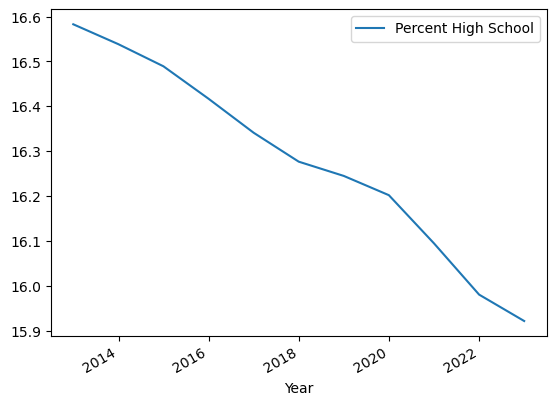

In [25]:
# Slicing for the percent of the population with a high school education
grph_hs_edu = pop_data[[
                        'Year',
                        'Percent High School'
                      ]]

# Grouping by `Year` for national averages
grph_hs_edu = grph_hs_edu.groupby('Year').mean()

# Quick plotting of data
grph_hs_edu.plot()

Interesting how this metric was on the decline even before Covid, and slightly accelerated after. Still, given the preceding graph, it is likely that much of the population that eschews a high school education is pursuing that same qualification through a GED, or some other means such as a profressional education.

<Axes: xlabel='Year'>

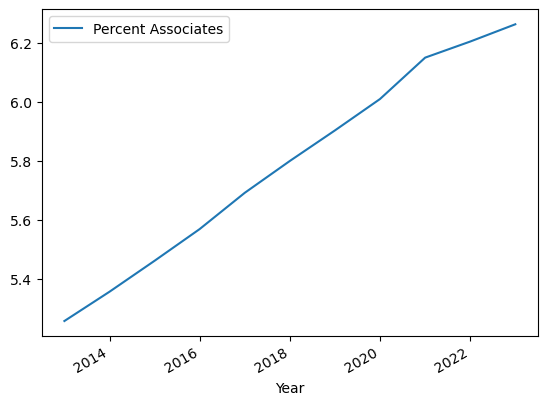

In [26]:
# Slicing for the percent of the population with an associates degree
grph_as_edu = pop_data[[
                        'Year',
                        'Percent Associates'
                      ]]

# Grouping by `Year` for national averages
grph_as_edu = grph_as_edu.groupby('Year').mean()

# Quick plotting of data
grph_as_edu.plot()

<Axes: xlabel='Year'>

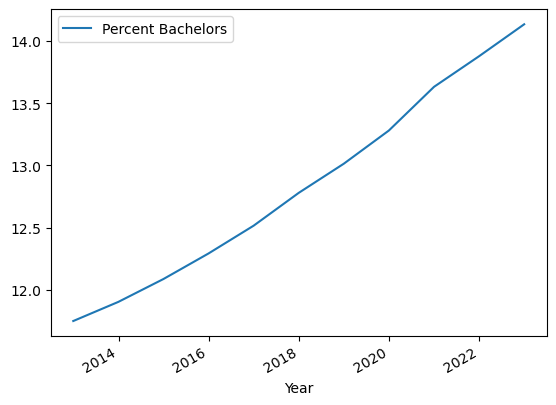

In [27]:
# Slicing for the percent of the population with a bachelors degree
grph_bd_edu = pop_data[[
                        'Year',
                        'Percent Bachelors'
                      ]]

# Grouping by `Year` for national averages
grph_bd_edu = grph_bd_edu.groupby('Year').mean()

# Quick plotting of data
grph_bd_edu.plot()

<Axes: xlabel='Year'>

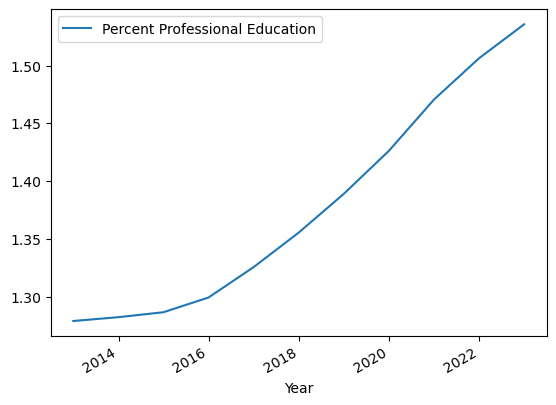

In [28]:
# Slicing for the percent of the population with a professinal education
grph_pr_edu = pop_data[[
                        'Year',
                        'Percent Professional Education'
                      ]]

# Grouping by `Year` for national averages
grph_pr_edu = grph_pr_edu.groupby('Year').mean()

# Quick plotting of data
grph_pr_edu.plot()

While telling on its own, the steady rise in professional education (programs like this boot camp, on-the-job training, apprenticeships, etc) does begin putting into perspective a potential national shift in priorities. While earlier graphs show a departure from the emphasis put on a high school education in favor of a GED, this, too, adds credence to the possibility of educations outside the realm of strict academia being the trend of the future.

<Axes: xlabel='Year'>

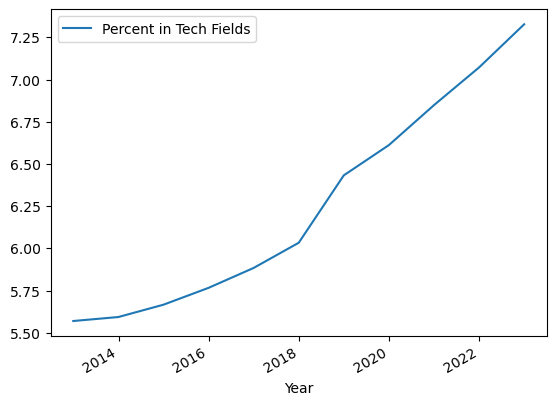

In [29]:
# Slicing for the percent of the population working in tech-related fields
grph_tj_pct = pop_data[[
                        'Year',
                        'Percent in Tech Fields'
                      ]]

# Grouping by `Year` for national averages
grph_tj_pct = grph_tj_pct.groupby('Year').mean()

# Quick plotting of data
grph_tj_pct.plot()

Perhaps even more telling, an even sharper rise in the prevelance of tech-related jobs seems to align with the same trends in profressional education. While not a complete picture, given that the tech fields have a larger relationship to the growth in AI and ML technologies and positions, it would be easy to see how the two (the percentage of people working in tech-related jobs and the percentage of people with a professional education) could be directly related. Much as we enrolled in this program to shift into the ML sector, many could be pursuing similar programs to shift into this or other sectors within the fields of technology.

<Axes: xlabel='Year'>

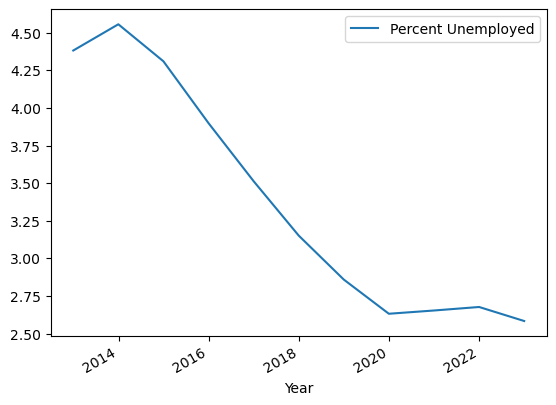

In [30]:
# Slicing for the percent of the population who are unemployed
grph_un_pct = pop_data[[
                        'Year',
                        'Percent Unemployed'
                      ]]

# Grouping by `Year` for national averages
grph_un_pct = grph_un_pct.groupby('Year').mean()

# Quick plotting of data
grph_un_pct.plot()

The national unemployment numbers have been on a steady decline over the previous decade, and seemed to have relatively stabalized in the years following Covid. Again, while not a complete picture, it is interesting to see how similarly the unemployment rates have decreased in comparrison to the rise in tech-related jobs. It is a possibility that the expansion of tech sectors *and* the increases in available profressional educations could be directly impacting the job market in such a way to help alleviate unemployment.

array([<Axes: xlabel='Year'>, <Axes: xlabel='Year'>], dtype=object)

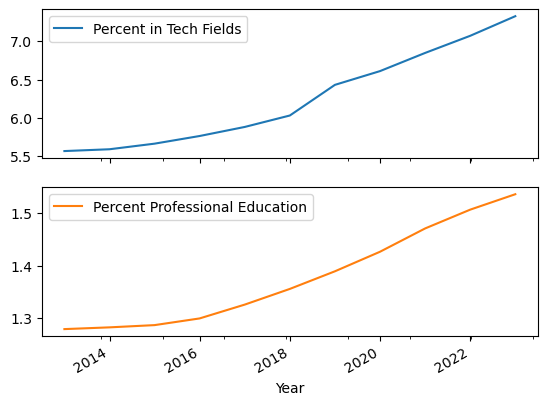

In [31]:
# Slicing for the percent of the population working in tech-related fields
# and with a profressinal education
grph_comp_tj_pr = pop_data[[
                            'Year',
                            'Percent in Tech Fields',
                            'Percent Professional Education'
                          ]]

# Grouping by `Year` for national averages
grph_comp_tj_pr = grph_comp_tj_pr.groupby('Year').mean()

# Quick plotting of data
grph_comp_tj_pr.plot(subplots=True)

When more directly comparing the trends in tech-related jobs and professional education rates it becomes clearer how closely the two metrics seem to grow. As the two subplots are on slightly different scales, it may appear that the two may have a more positive correlation that they might.

In [32]:
# Calculating the minimum and maximum values for `Percent Professional Education`
min_tech = grph_comp_tj_pr['Percent in Tech Fields'].min()
max_tech = grph_comp_tj_pr['Percent in Tech Fields'].max()

# Calculating the difference
tech_chng = max_tech - min_tech

# Calculating the minimum and maximum values for `Percent in Tech Fields`
min_edup = grph_comp_tj_pr['Percent Professional Education'].min()
max_edup = grph_comp_tj_pr['Percent Professional Education'].max()

# Calculating the difference
edup_chng = max_edup - min_edup

# Printing the results
print(f'The lowest percentage of people working in tech related fields was: {round(min_tech, 2)}%')
print(f'The highest percentage of people working in tech related fields was: {round(max_tech, 2)}%')
print(f'This was a growth of: {round(tech_chng, 2)}%\n')
print(f'The lowest percentage of people with a profressional education was: {round(min_edup, 2)}%')
print(f'The highest percentage of people with a profressional education was: {round(max_edup, 2)}%')
print(f'This was a growth of: {round(edup_chng, 2)}%\n')

The lowest percentage of people working in tech related fields was: 5.57%
The highest percentage of people working in tech related fields was: 7.33%
This was a growth of: 1.76%

The lowest percentage of people with a profressional education was: 1.28%
The highest percentage of people with a profressional education was: 1.54%
This was a growth of: 0.26%



Clearly not as closely related as first impressions might show, there is still definitive growth in both areas. Further analysis on the correlation may be needed, but the conlcusion that an increase in the availablity and prevelance of tech-related jobs and the growing trends in pursuing a professinal education are inherently connected may be a safe one to draw.

array([<Axes: xlabel='Year'>, <Axes: xlabel='Year'>], dtype=object)

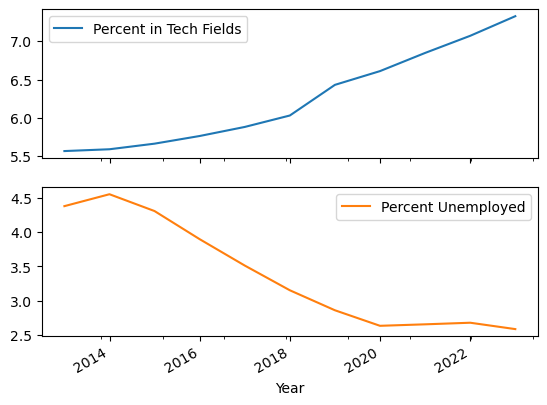

In [33]:
# Slicing for the percent of the population working in tech-related fields
# and the percent of the population who are unemployed
grph_comp_tj_un = pop_data[[
                            'Year',
                            'Percent in Tech Fields',
                            'Percent Unemployed'
                          ]]

# Grouping by `Year` for national averages
grph_comp_tj_un = grph_comp_tj_un.groupby('Year').mean()

# Quick plotting of data
grph_comp_tj_un.plot(subplots=True)

Similarly as before, a slight difference of scale in these subplots warrants further examination.

In [34]:
# Calculating the minimum and maximum values for `Percent Professional Education`
min_tech = grph_comp_tj_un['Percent in Tech Fields'].min()
max_tech = grph_comp_tj_un['Percent in Tech Fields'].max()

# Calculating the difference
tech_chng = max_tech - min_tech

# Calculating the minimum and maximum values for `Percent in Tech Fields`
min_unem = grph_comp_tj_un['Percent Unemployed'].min()
max_unem = grph_comp_tj_un['Percent Unemployed'].max()

# Calculating the difference
unem_chng = -(max_unem - min_unem)

# Printing the results
print(f'The lowest percentage of people working in tech related fields was: {round(min_tech, 2)}%')
print(f'The highest percentage of people working in tech related fields was: {round(max_tech, 2)}%')
print(f'This was a growth of: {round(tech_chng, 2)}%\n')
print(f'The lowest percentage of people who were unemployed was: {round(min_unem, 2)}%')
print(f'The highest percentage of people who were unemployed was: {round(max_unem, 2)}%')
print(f'This was a decrease of: {round(unem_chng, 2)}%\n')

The lowest percentage of people working in tech related fields was: 5.57%
The highest percentage of people working in tech related fields was: 7.33%
This was a growth of: 1.76%

The lowest percentage of people who were unemployed was: 2.58%
The highest percentage of people who were unemployed was: 4.56%
This was a decrease of: -1.97%



Unemployment is a largely complicated metric to examine in any capacity, let alone a simple comparrison to a partially related trend. Many more factors play into the national unemployment numbers, so it would be wholly unfair to say an increase in tech-related jobs is solving unemployment issues across the nation. However, given how closely the trends have grown and decreased, it would be a safe assumption to make that a larger number of available technical job opporunities ***does*** contribute to part of the overall solution.

array([<Axes: xlabel='Year'>, <Axes: xlabel='Year'>,
       <Axes: xlabel='Year'>, <Axes: xlabel='Year'>], dtype=object)

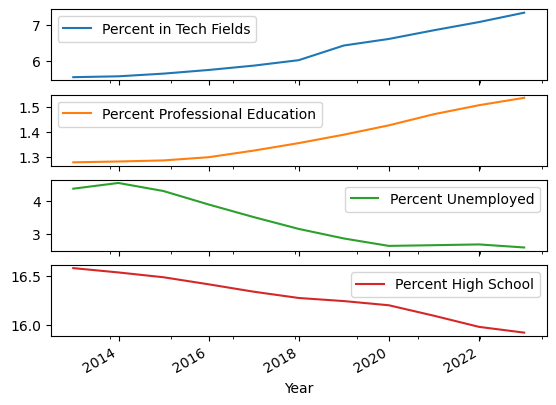

In [35]:
grph_comp_4way = pop_data[[
                            'Year',
                            'Percent in Tech Fields',
                            'Percent Professional Education',
                            'Percent Unemployed',
                            'Percent High School'
                          ]]

grph_comp_4way = grph_comp_4way.groupby('Year').mean()

grph_comp_4way.plot(subplots=True)

Similar to the previous two subplots, the addition of a decrease in the percentage of the population with a high school eductaion similarly speaks as an incomplete section of a larger picture. While the trends appear similar at large, there are many more factors at play than the available dataset allows for deeper examination.

### Preparing Visualiztions

Given some of the findings above, the following visualizations on national trends are prepared for the final presentation

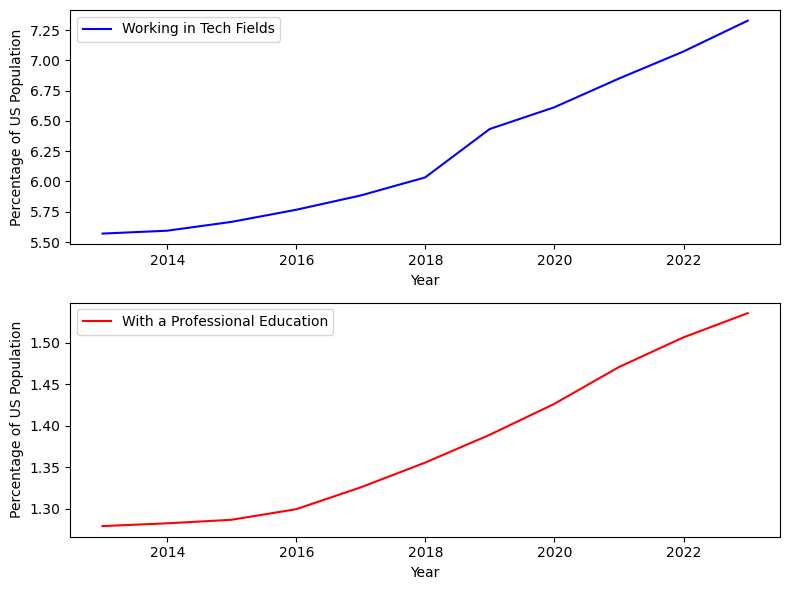

In [36]:
# Create a figure and subplots
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(8, 6))

# Plot 'Percent in Tech Fields'
axes[0].plot(grph_comp_tj_pr.index, grph_comp_tj_pr['Percent in Tech Fields'], label='Working in Tech Fields', color='blue')
axes[0].set_xlabel('Year')
axes[0].set_ylabel('Percentage of US Population')
axes[0].legend()

# Plot 'Percent Professional Education'
axes[1].plot(grph_comp_tj_pr.index, grph_comp_tj_pr['Percent Professional Education'], label='With a Professional Education', color='red')
axes[1].set_xlabel('Year')
axes[1].set_ylabel('Percentage of US Population')
axes[1].legend()

# Adjust layout and save the figure
plt.tight_layout()
#plt.savefig('comp_tech_v_profedu_subplots.png', dpi=300) #Commented out to prevent redundant files
plt.show()


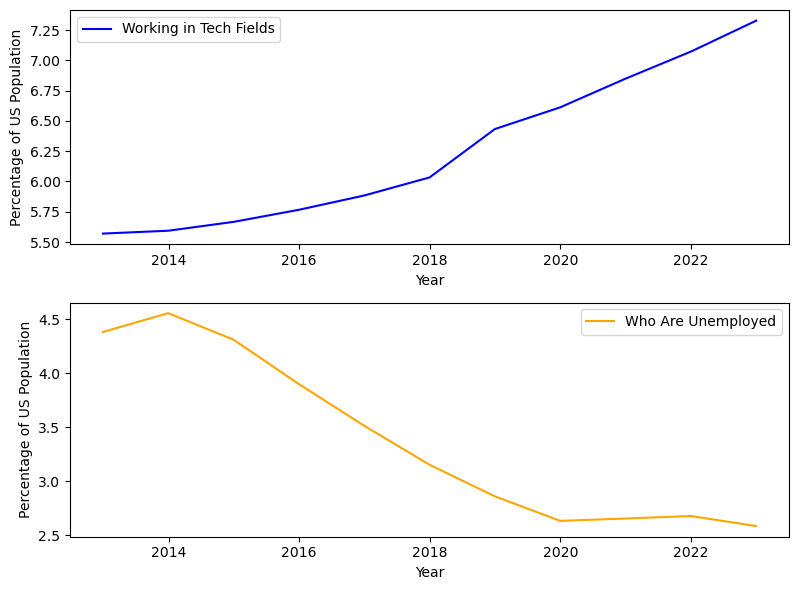

In [37]:
# Creating a figure and subplots
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(8, 6))

# Plotting 'Percent in Tech Fields'
axes[0].plot(grph_comp_tj_un.index, grph_comp_tj_un['Percent in Tech Fields'], label='Working in Tech Fields', color='blue')
axes[0].set_xlabel('Year')
axes[0].set_ylabel('Percentage of US Population')
axes[0].legend()

# Plotting 'Percent Unemployed'
axes[1].plot(grph_comp_tj_un.index, grph_comp_tj_un['Percent Unemployed'], label='Who Are Unemployed', color='orange')
axes[1].set_xlabel('Year')
axes[1].set_ylabel('Percentage of US Population')
axes[1].legend()

# Adjusting layout and saving the figure
plt.tight_layout()
#plt.savefig('comp_tech_v_unemp_subplots.png', dpi=300) #Commented out to prevent redundant files
plt.show()

### Correlations

With the above visualizations prepared, a closer look at the correlations among the various levels of education, unemployment rates, and the growth in tech-related jobs seems justified.

In [38]:
# Slicing relevant informent from `pop_data` and grouping by `Year` to give
# the national averages by year
national_avg_pct = pop_data[[
                            'Year',
                            'Percent Unemployed',
                            'Percent in Tech Fields',
                            'Percent No Education',
                            'Percent High School',
                            'Percent GED',
                            'Percent Associates',
                            'Percent Bachelors',
                            'Percent Professional Education'
                           ]].groupby('Year').mean()

In [39]:
# Calculating the correlations among the selected columns
national_avg_pct[[
                  'Percent in Tech Fields',
                  'Percent Unemployed',
                  'Percent No Education',
                  'Percent High School',
                  'Percent GED',
                  'Percent Professional Education'
                ]].corr()

,Percent in Tech Fields,Percent Unemployed,Percent No Education,Percent High School,Percent GED,Percent Professional Education
Percent in Tech Fields,1.000000,-0.908355,0.935407,-0.978474,0.769157,0.997118
Percent Unemployed,-0.908355,1.000000,-0.770727,0.925948,-0.932187,-0.902584
Percent No Education,0.935407,-0.770727,1.000000,-0.948015,0.664332,0.939702
Percent High School,-0.978474,0.925948,-0.948015,1.000000,-0.839118,-0.981718
Percent GED,0.769157,-0.932187,0.664332,-0.839118,1.000000,0.761740
Percent Professional Education,0.997118,-0.902584,0.939702,-0.981718,0.761740,1.000000


* Percent in Tech Fields and Percent Unemployed:
    * Again, not a complete story - seeing as many more variables affect unemployment rates - but such a strong relationship suggests that the trends might continue to behave similarly
* Percent in Tech Fields and Percent No Education:
    * An interesting closeness, escpecially with the context that the correlation between tech-related jobs and percentage of the population with a GED are *not* as close (discussed below)
* Percent in Tech Fields and Percent Percent High School:
    * Even closer to a 1:-1 than as seen with unemployment rates, the trends might suggest that those moving away from traditional academia may be looking towards the tech sectors for future employment
* Percent in Tech Fields and Percent Percent GED:
    * One might expect this to be an inverse of the previous correlation, but the connection between receiving a GED and working in the tech field seems to be significantly lower than with other metrics being explored here
    * In point of fact, among the selected columns, the strongest correlation with percentage of the population with a GED seems to be the percent of unemployed people with another near 1:-1 relationshio
* Percent in Tech Fields and Percent Percent Professional Education:
    * Perhaps the most telling of all is this almost perfectly 1:1 relationship, suggesting an almost difinitive connection between alternative forms of education and the growth of tech-related jobs in our country
    * While also not a complete picture, this trend validates the importance of programs such as this boot camp in terms of developing a stronger tech workforce



### Predictions

Using the slices prepared earlier, multiple sets of data are passed through Prophet to give a 5-year prediction based on the US Census data.

In [40]:
# Declaring an instance for Prophet for `Percent in Tech Fields`
m_n_t = Prophet()

In [41]:
# Fitting the model to the appropriately sliced DataFrame
m_n_t.fit(national_tech)

21:59:22 - cmdstanpy - INFO - Chain [1] start processing
21:59:26 - cmdstanpy - INFO - Chain [1] done processing


In [42]:
# Creating rows for 5 years' worth of predictions
n_tech_future = m_n_t.make_future_dataframe(periods=5, freq='YE')

In [43]:
# Running predictions
n_tech_forecast = m_n_t.predict(n_tech_future)

/opt/anaconda3/envs/ai_dev/lib/python3.10/site-packages/prophet/plot.py:71: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/opt/anaconda3/envs/ai_dev/lib/python3.10/site-packages/prophet/plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


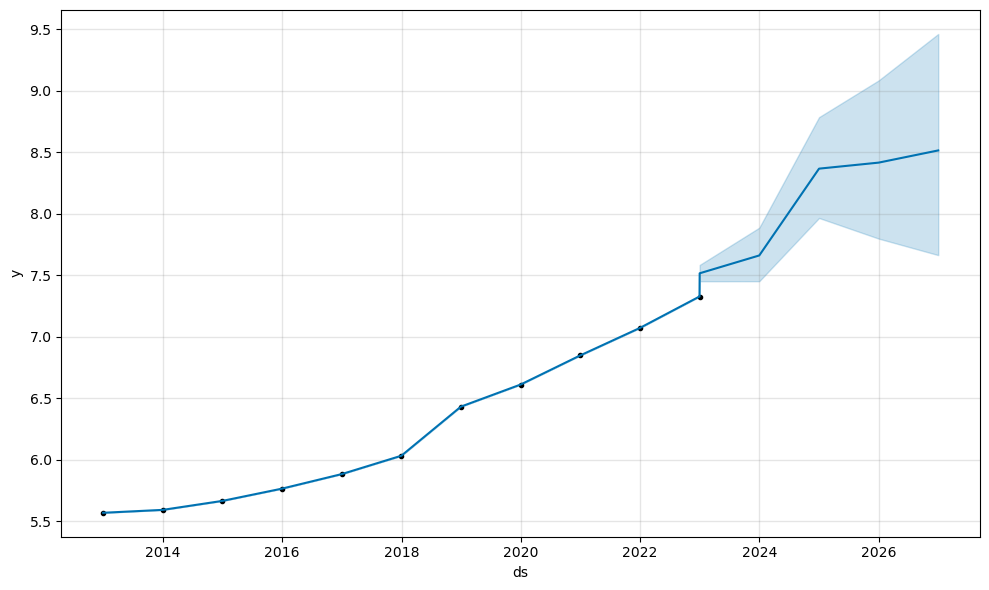

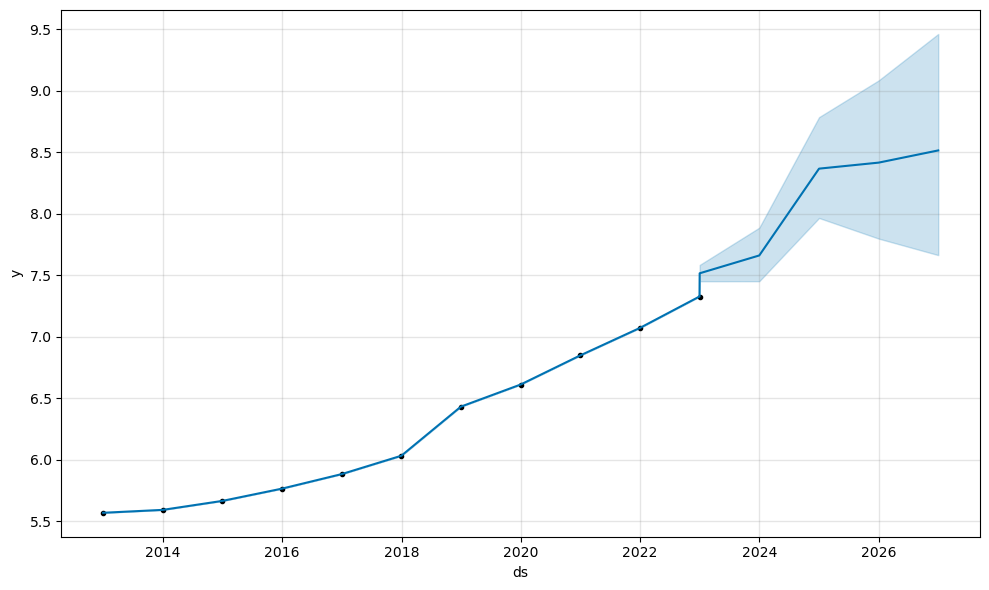

In [44]:
# Plotting the results
m_n_t.plot(n_tech_forecast)

Prophet paints a clear image of moderate to near-exponential copntinued growth in the tech sectors.

In [45]:
# Declaring an instance for Prophet for `Percent Professional Education`
m_n_e_p = Prophet()

In [46]:
# Fitting the model to the appropriately sliced DataFrame
m_n_e_p.fit(national_edu_prf)

21:59:26 - cmdstanpy - INFO - Chain [1] start processing
21:59:29 - cmdstanpy - INFO - Chain [1] done processing


In [47]:
# Creating rows for 5 years' worth of predictions
n_prf_future = m_n_e_p.make_future_dataframe(periods=5, freq='YE')

In [48]:
# Running predictions
n_prf_forecast = m_n_e_p.predict(n_prf_future)

/opt/anaconda3/envs/ai_dev/lib/python3.10/site-packages/prophet/plot.py:71: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/opt/anaconda3/envs/ai_dev/lib/python3.10/site-packages/prophet/plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


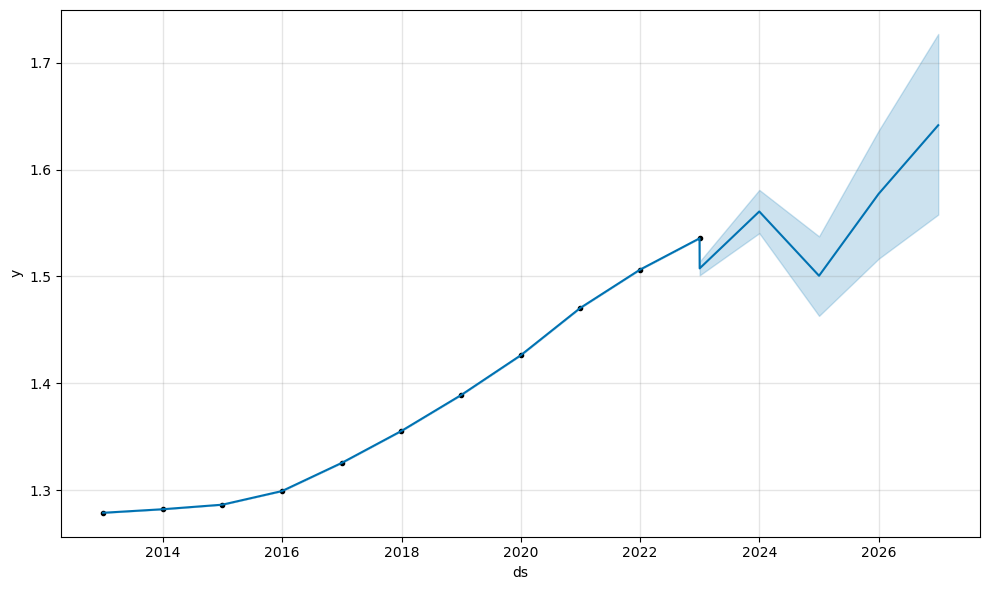

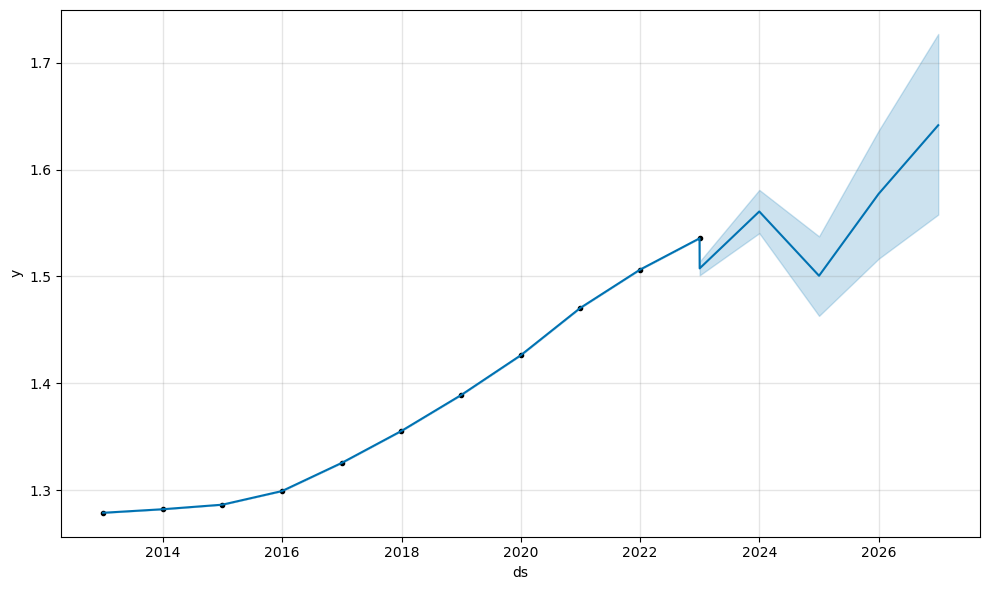

In [49]:
# Plotting the results
m_n_e_p.plot(n_prf_forecast)

Similarly, Prophet seems to predict overall growth in the trends for professional education that - at a glance - nearly mirrors the projections for the tech-related jobs as shown above.

In [50]:
# Declaring an instance for Prophet for `Percent Associates`
m_n_e_a = Prophet()

In [51]:
# Fitting the model to the appropriately sliced DataFrame
m_n_e_a.fit(national_edu_asc)

21:59:29 - cmdstanpy - INFO - Chain [1] start processing
21:59:33 - cmdstanpy - INFO - Chain [1] done processing


In [52]:
# Creating rows for 5 years' worth of predictions
n_asc_future = m_n_e_a.make_future_dataframe(periods=5, freq='YE')

In [53]:
# Running predictions
n_asc_forecast = m_n_e_a.predict(n_asc_future)

/opt/anaconda3/envs/ai_dev/lib/python3.10/site-packages/prophet/plot.py:71: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/opt/anaconda3/envs/ai_dev/lib/python3.10/site-packages/prophet/plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


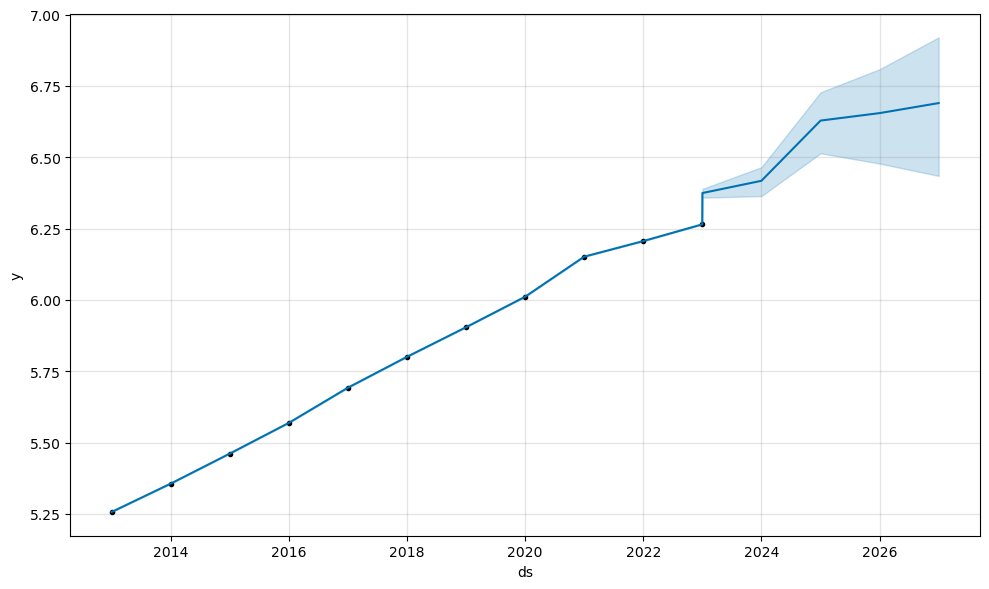

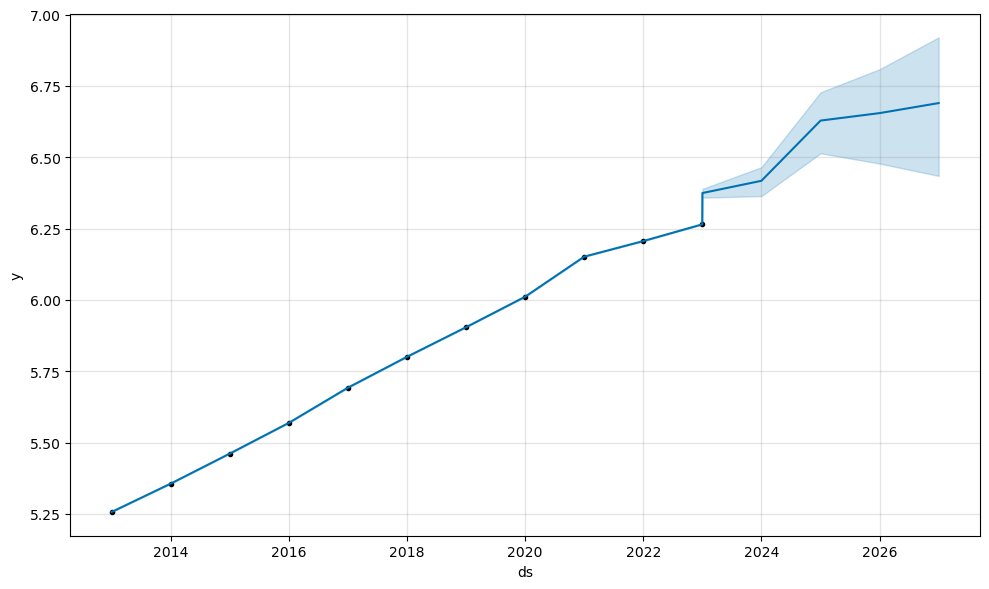

In [54]:
# Plotting the results
m_n_e_a.plot(n_asc_forecast)

In [55]:
# Declaring an instance for Prophet for `Percent High School`
m_n_e_h = Prophet()

In [56]:
# Fitting the model to the appropriately sliced DataFrame
m_n_e_h.fit(national_edu_hs)

21:59:33 - cmdstanpy - INFO - Chain [1] start processing
21:59:36 - cmdstanpy - INFO - Chain [1] done processing


In [57]:
# Creating rows for 5 years' worth of predictions
n_hs_future = m_n_e_h.make_future_dataframe(periods=5, freq='YE')

In [58]:
# Running predictions
n_hs_forecast = m_n_e_h.predict(n_hs_future)

/opt/anaconda3/envs/ai_dev/lib/python3.10/site-packages/prophet/plot.py:71: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/opt/anaconda3/envs/ai_dev/lib/python3.10/site-packages/prophet/plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


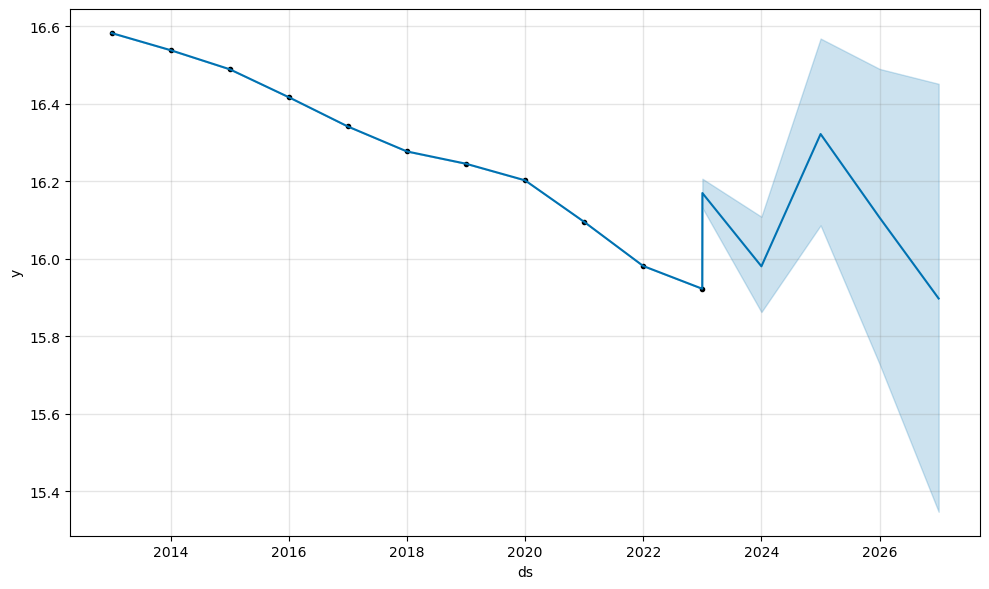

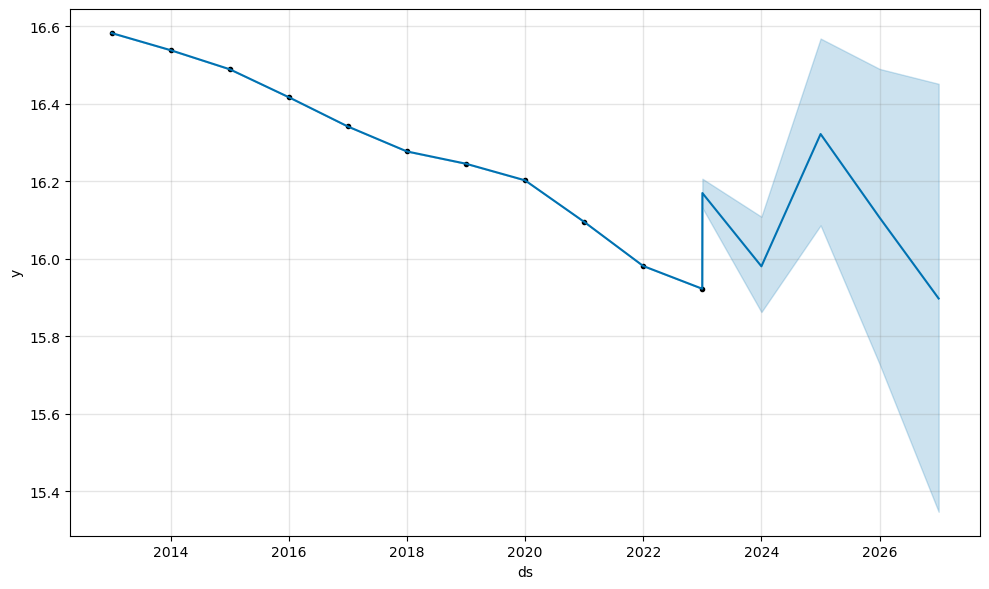

In [59]:
# Plotting the results
m_n_e_h.plot(n_hs_forecast)

Unsure as to why such drastic spikes came from the predictive model. This could be due to using a rolling 5-year average, meaning alternative, cleaner data may be required for deeper analysis.

In [60]:
# Declaring an instance for Prophet for `Percent GED`
m_n_e_g = Prophet()

In [61]:
# Fitting the model to the appropriately sliced DataFrame
m_n_e_g.fit(national_edu_ged)

21:59:36 - cmdstanpy - INFO - Chain [1] start processing
21:59:40 - cmdstanpy - INFO - Chain [1] done processing


In [62]:
# Creating rows for 5 years' worth of predictions
n_ged_future = m_n_e_g.make_future_dataframe(periods=5, freq='YE')

In [63]:
# Running predictions
n_ged_forecast = m_n_e_g.predict(n_ged_future)

/opt/anaconda3/envs/ai_dev/lib/python3.10/site-packages/prophet/plot.py:71: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/opt/anaconda3/envs/ai_dev/lib/python3.10/site-packages/prophet/plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


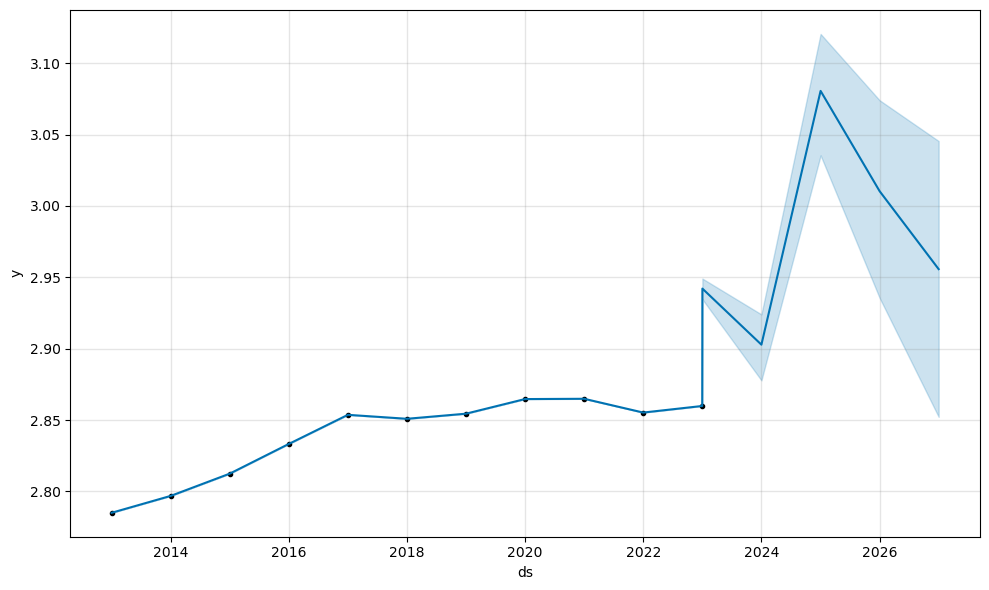

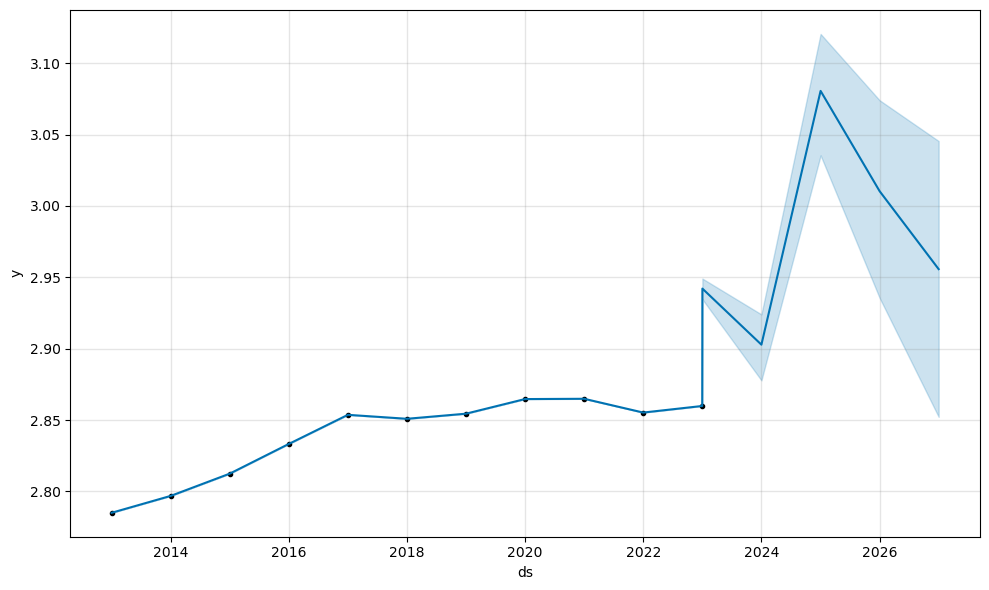

In [64]:
# Plotting the results
m_n_e_g.plot(n_ged_forecast)

Same as with `Percent High School`, the spikes in this model indicate alternative data might be needed for closer examination.

In [65]:
# Declaring an instance for Prophet for `Percent Unemployed`
m_n_u = Prophet()

In [66]:
# Fitting the model to the appropriately sliced DataFrame
m_n_u.fit(national_unemp)

21:59:40 - cmdstanpy - INFO - Chain [1] start processing
21:59:40 - cmdstanpy - INFO - Chain [1] done processing


In [67]:
# Creating rows for 5 years' worth of predictions
n_unemp_future = m_n_u.make_future_dataframe(periods=5, freq='YE')

In [68]:
# Running predictions
n_unemp_forecast = m_n_u.predict(n_unemp_future)

/opt/anaconda3/envs/ai_dev/lib/python3.10/site-packages/prophet/plot.py:71: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/opt/anaconda3/envs/ai_dev/lib/python3.10/site-packages/prophet/plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


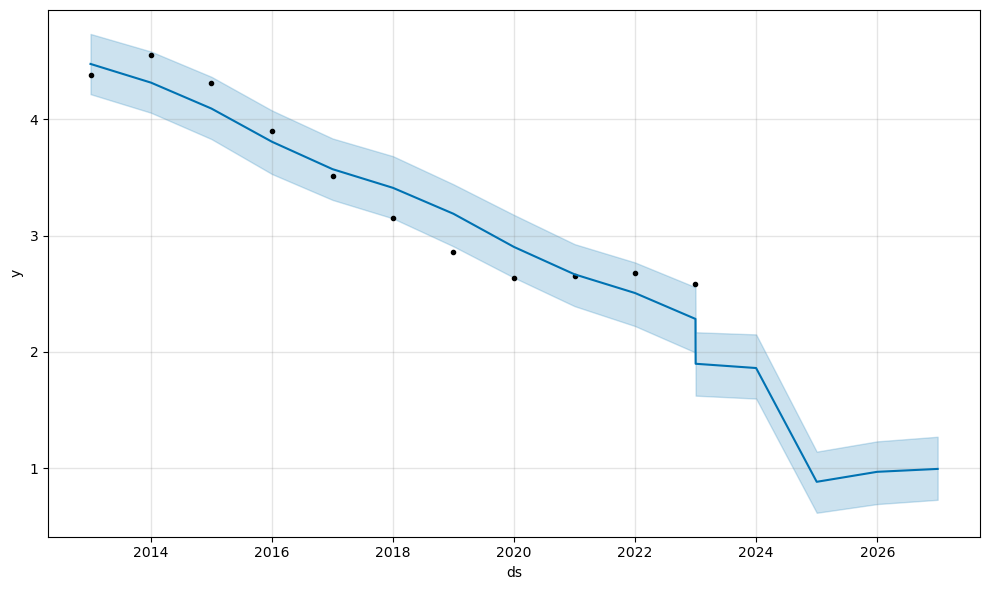

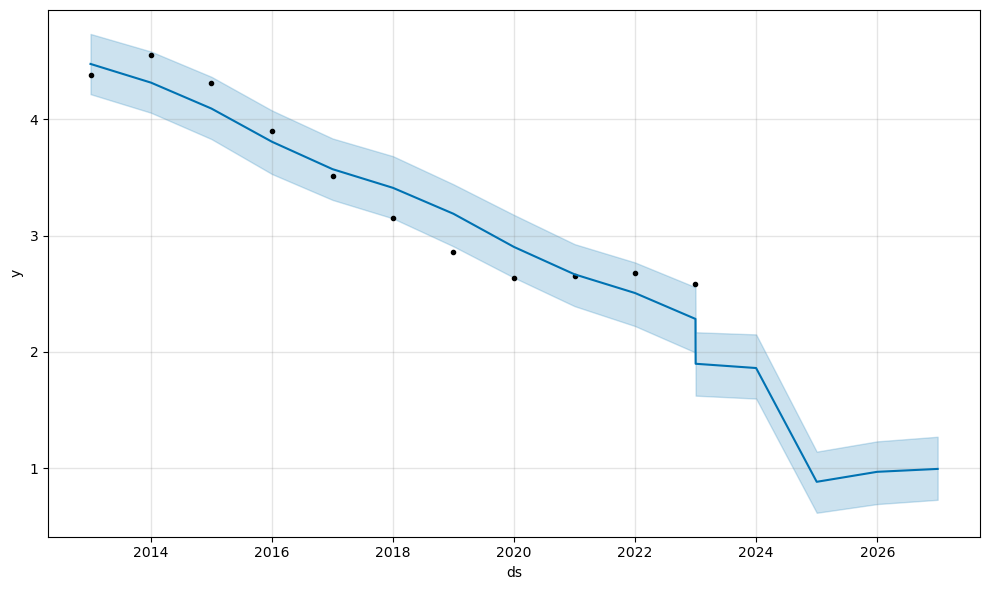

In [69]:
# Plotting the results
m_n_u.plot(n_unemp_forecast)

While also a little choppy in presentaion, the overall trend in this prediction on unemployment rates does seem to align with the provided values from the US Census data. Still complicated by variables beyond the scope of this analysis, Prophet's predictions do speak to a potential low in unemployment rates for the nation. Such a prediciton is made all the most interesting when compared to the plot for `Percent in Tech Fields`. Again, tech jobs are only part of the overall contributions to efforts being made through other avenues to lower unemployment numbers, but a healthy relationship between the growth of one and the decline of the other does seem to be present.

### Predictions (A Closer Look)

Taking a deeper look at the predictions Prophet made for `Percent in Tech Fields` and `Percent Unemployed`

<Axes: >

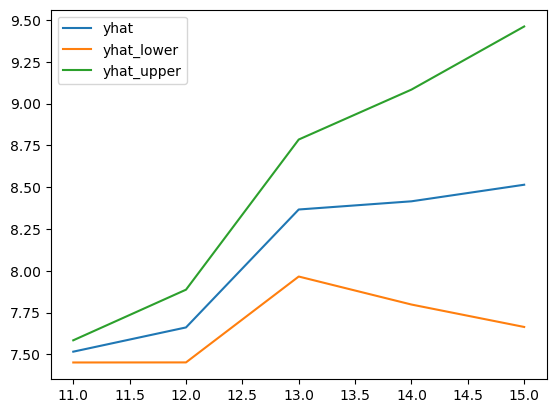

In [70]:
# Taking a closer look at the 5-year prediction ranges made for `Percent in Tech Fields`
n_tech_forecast[['yhat', 'yhat_lower', 'yhat_upper']].iloc[-5:,:].plot()

In [71]:
# Calculating the ranges of predictions at the end of the 5 years for `Percent in Tech Fields`
predict_tech_min = n_tech_forecast['yhat_lower'].iloc[-1]
predict_tech_mid = n_tech_forecast['yhat'].iloc[-1]
predict_tech_max = n_tech_forecast['yhat_upper'].iloc[-1]

# Printing predictions
print(f'The lowest prediction for percentage of the population working in tech-related jobs is: {round(predict_tech_min, 2)}%')
print(f'The middle prediction for percentage of the population working in tech-related jobs is: {round(predict_tech_mid, 2)}%')
print(f'The highest prediction for percentage of the population working in tech-related jobs is: {round(predict_tech_max, 2)}%')

The lowest prediction for percentage of the population working in tech-related jobs is: 7.66%
The middle prediction for percentage of the population working in tech-related jobs is: 8.51%
The highest prediction for percentage of the population working in tech-related jobs is: 9.46%


All outcomes seem plausible based on the available data.

<Axes: >

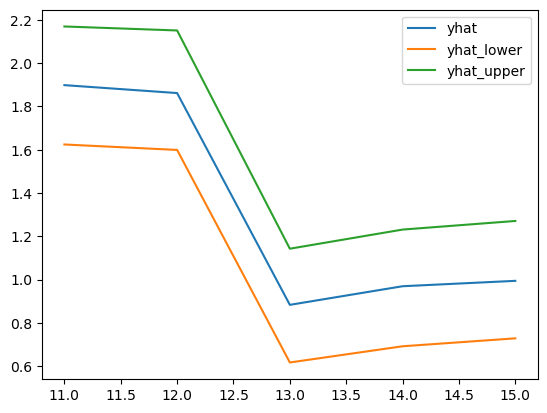

In [72]:
# Taking a closer look at the 5-year prediction ranges made for `Percent Unemployed`
n_unemp_forecast[['yhat', 'yhat_lower', 'yhat_upper']].iloc[-5:,:].plot()

In [73]:
# Calculating the ranges of predictions at the end of the 5 years for `Percent Unemployed`
predict_unem_min = n_unemp_forecast['yhat_lower'].iloc[-1]
predict_unem_mid = n_unemp_forecast['yhat'].iloc[-1]
predict_unem_max = n_unemp_forecast['yhat_upper'].iloc[-1]

# Printing predictions
print(f'The lowest prediction for the unemployed percentage of the population is: {round(predict_unem_min, 2)}%')
print(f'The middle prediction for the unemployed percentage of the population is: {round(predict_unem_mid, 2)}%')
print(f'The highest prediction for the unemployed percentage of the population is: {round(predict_unem_max, 2)}%')

The lowest prediction for the unemployed percentage of the population is: 0.73%
The middle prediction for the unemployed percentage of the population is: 0.99%
The highest prediction for the unemployed percentage of the population is: 1.27%


Seeing as the lowest rate for national unemployment to date has been 3.6% (__[as per Statista](https://www.statista.com/statistics/193290/unemployment-rate-in-the-usa-since-1990/#:~:text=By%20the%20end%20of%202022,Both%20are%20seasonally%20adjusted.)__), none of these predictions feel attainable. An interesting exercise in thought, but the subject may be far beyond Prophet's abilities to predict - especially with the limitted data available for this exploration.

/opt/anaconda3/envs/ai_dev/lib/python3.10/site-packages/prophet/plot.py:71: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/opt/anaconda3/envs/ai_dev/lib/python3.10/site-packages/prophet/plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


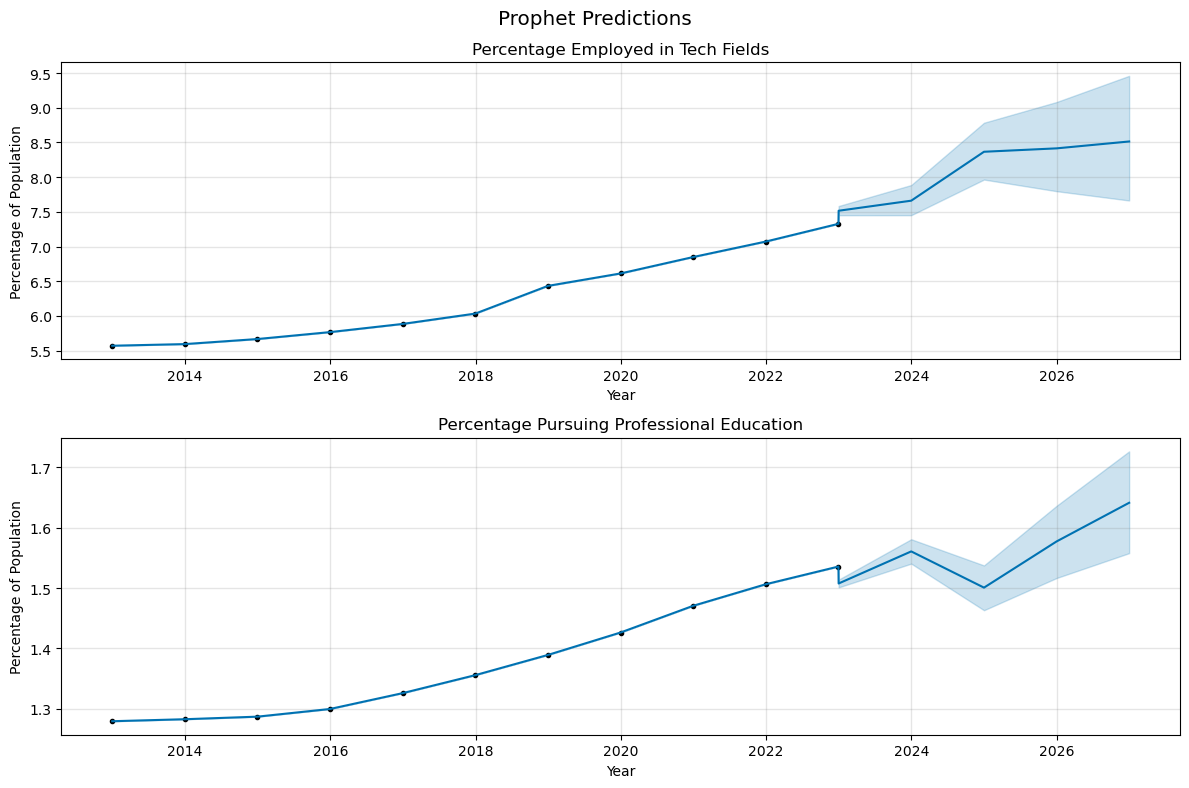

In [74]:
# Creating subplots for earlier forecasts
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(12, 8))

# Plotting forecast for `n_tech_forecast`
m_n_t.plot(n_tech_forecast, ax=axes[0])
axes[0].set_title('Percentage Employed in Tech Fields')
axes[0].set_xlabel('Year')
axes[0].set_ylabel('Percentage of Population')

# Plotting forecast for `n_prf_forecast`
m_n_e_p.plot(n_prf_forecast, ax=axes[1])
axes[1].set_title('Percentage Pursuing Professional Education')
axes[1].set_xlabel('Year')
axes[1].set_ylabel('Percentage of Population')

# Adding a title to the plot
plt.suptitle('Prophet Predictions', x=0.5, y=0.98, ha='center', fontsize='x-large')

# Adjusting layout and saving the figure
plt.tight_layout()
#plt.savefig('comp_tech_v_profedu_predict.png', dpi=300) #Commented out to prevent redundant files
plt.show()

# US Census Summary

After more closely examining the US Census data for trends and patterns in how tech-related jobs correlate to education and employment rates in our country, the following can be said;

#### Education Trends

There is a definite trend over the past decade in a departure from traditional academia. While the percentage of the US population with more advanced degrees (eg; associates, bachelors, and masters) seems to be on a steady increase, other metrics have seen far more drastic changes. The percentage of the population without a high school education (eg; no education or GED in lieu of a traditional high school diploma) have seem massive surges in the years examined. Given the effect of Covid on the American education system, there are likely factors beyond the scope of the available data at play. That said, both the percentage of the population no education *and* the percentage of the population with a high school degree share similar and inverse correlations to the percentage of the population working in tech-related fields (1:0.935 and 1:-0.978, respectively).

Perhaps the strongest case can be made for the connection between tech-related jobs and professional education. With a 1:0.997 correlation (the single strongest found in this dataset), a clear image is painted of the importance of programs (such as this boot camp) for training the skills necessary to work in such fields. With a growing number of the population seeking alternative methods for education, and a large demand for highly-specific skillsets, a national trend moving towards more customizable, directly-applicatble learning makes sense. And, with AI and ML job demands being a subset of the overall tech sector, the growth of such positions would inherently help to drive further demand for both the jobs and programs to train the skills necessary for them.

#### Unemployment Trends

When compared to the percentage of the population working in tech-related fields, the unemployment percentage appears somewhat related (a 1:-0.908 correlation). However, these numbers are being generated by a rolling 5-year national average, and are not indicative of all the variables playing into the unemployment rates. There is a case to be made for the growth in tech sectors helping to combat unemployment rates, but it must be acknowledged that the data used in this analysis does not -  and cannot - tell the whole story. Far more data, from more varied sources, would be necessary to draw more concrete conclusions about the connections between tech jobs and unemployment.

##### Future Analysis

Much of the analysis done with the US Census data is limited in scope. Comprised of 10 years' worth of rolling 5-year estimates, there is room for both interpretation and improvement. Ideally, if further research is pursued, using the Census' ACS1 might be prefereble to the ACS5 dataset used here. Additional supplementary data would help to further strengthen any correlations drawn - specifically data relating to how tech-related jobs are affecting layoffs and unemployment rates more directly. Furthermore, a more granular subset of tech-related jobs (those directly connected to AI and ML jobs) would helpe more closesly relate the findings to the overall question of how such jobs interact with other aspects of employment and education. Given the methodology of how the US Census Bureau tracks fields of employment, this would absolutely necessetate seeking alternative data sources. However, most applicable sources remain behind paywalls and are inaccessable for the purposes of this project. With access to a wider variety of information, though, more concerete conclusions may be found with further exploration.

**Section 2: Relative Comparisons of Tech Workers with/without Machine Learning **
Another dimension by which to look at the growth of machine learning is to compare software developers *with* ML experience to those *without* machine learning experience. Layoffs among general tech workers have been pronounced in recent months [Link](https://layoffs.fyi/) yet demand for Machine Learning engineers has reportedly increased 42% on Hired's platform [Link](https://hired.com/resources/articles/trends-software-engineer-specializations/) . This demonstrates that as a specialization, ML ought to be treated separately from other tech skills.

***Basic metrics***
As a firsts step, we compare the relative proportion of machine learning related job listings to those lacking that term. We achieve this by doing a string match through the data set using a common list of ML related terms.

In [75]:
# Get all job listings with an AI related keyword  listed as a skill requirement 
terms_to_match = ['machine learning', 'artificial intelligence', 'pytorch', 'langchain', 'ai', 'tensorflow', 'deep learning', 'neural network', 
               'natural language processing', 'nlp', 'computer vision', 'large language models', 'chatbot', 'ai chatbot', 'llm', 'llms', 'generative ai', 'generative models', 'genai', 'bert', 'spacy', 'nltk', 'keras', 'gpt', 'chatgpt', 'prompt development', 'prompt engineering']

linkedin_postings_df['job_skills'] = linkedin_postings_df['job_skills']

linkedin_postings_df['has_ai'] = linkedin_postings_df['job_skills'].apply(
    lambda skills: any(term in skills for term in terms_to_match)
)
#Separate the groupings into two new dataframes
ai_roles = linkedin_postings_df.loc[linkedin_postings_df['has_ai'] == True]
# Job listings without AI keywords will be classified as "general" roles
general_roles = linkedin_postings_df.loc[linkedin_postings_df['has_ai'] == False]

Relative proportion of ML jobs to non-ML tech jobs

In [76]:
# Raw counts of ML to non-ML
display(linkedin_postings_df['has_ai'].value_counts())
# Proportion of ML to non-ML
display(linkedin_postings_df['has_ai'].value_counts(normalize=True))

has_ai
False    8469
True      898
Name: count, dtype: int64

has_ai
False    0.904132
True     0.095868
Name: proportion, dtype: float64

Given that x of the y job listings contain an AI related keyword, approximately z% of all listings are AI-related to some degree.

Another dimension we want to investigate is the relative proportion of job levels, or experience requirements. Considering that AI is a newer skill set, we predict a greater proportion of entry level positions compared to generic tech roles based on skills that have been around longer.

In [77]:
print(ai_roles['job level'].value_counts(normalize=True))
print(general_roles['job level'].value_counts(normalize=True))

job level
Mid senior    0.845212
Associate     0.154788
Name: proportion, dtype: float64
job level
Mid senior    0.865982
Associate     0.134018
Name: proportion, dtype: float64


We find that at least for this data set, the relative demand for associate versus mid-senior level developers for AI is almost identical to the relative demand of the same for general developers. Notably, demand for mid-senior is slightly lower for ML-related jobs, although it remains to be seen if this is statistically significant. 

Next, within the AI subset, we wanted to see which skills were most in demand. For this we will take our list of AI related job skill keywords and construct a new dataframe with a dictionary using the keywords as keys and the frequencies as values.  

In [78]:
# Use a list comprehension and the dict method to turn tuples into key value pairs
keyword_dict = dict([(keyword, 0) for keyword in terms_to_match])
# Count the frequencies the terms appear in each skill set
def increment_keywords(term_list:list, dictionary: dict): 
    for skill in term_list:
        if skill in dictionary:
            dictionary[skill] += 1
    return term_list
ai_roles['job_skills'].apply(lambda skills: increment_keywords(skills, keyword_dict))
#Convert dict to series 
ai_skill_series = pd.Series(keyword_dict)

# Here we clean up the data by de-duplicating different keyword lables and sum them together 
label_mapping = {'artificial intelligence': 'ai', 'natural language processing': 'nlp', 'large language models': 'llms', 'llm': 'llms', 'generative models' : 'genai', 'generative ai': 'genai'}

# Replace the labels in the series index
ai_skill_series.index = ai_skill_series.index.to_series().replace(label_mapping)

# Aggregate the data - sum the values with the same label
ai_skill_series = ai_skill_series.groupby(ai_skill_series.index).sum()

# Display the resulting series
print(ai_skill_series)

ai                    350
ai chatbot              1
bert                    1
chatbot                 1
chatgpt                 7
computer vision       101
deep learning          61
genai                  65
gpt                     1
keras                   5
langchain              12
llms                   44
machine learning      642
neural network          2
nlp                   103
nltk                    0
prompt development      0
prompt engineering     14
pytorch                57
spacy                   0
tensorflow             68
dtype: int64


<Axes: >

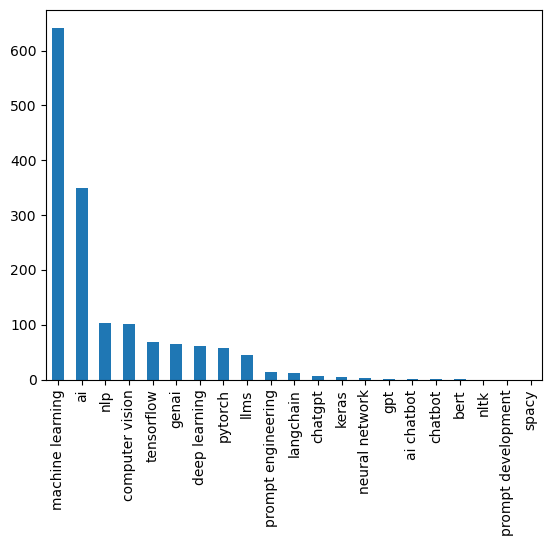

In [79]:
ai_skill_series.sort_values(ascending=False).plot(kind='bar')

We are also interested in the more general skill breakdown. Within the AI-related job listings, how in demand are the skills our previous term filter didn't control for?

<Axes: title={'center': 'Most in Demand Skills for AI Telated Jobs'}>

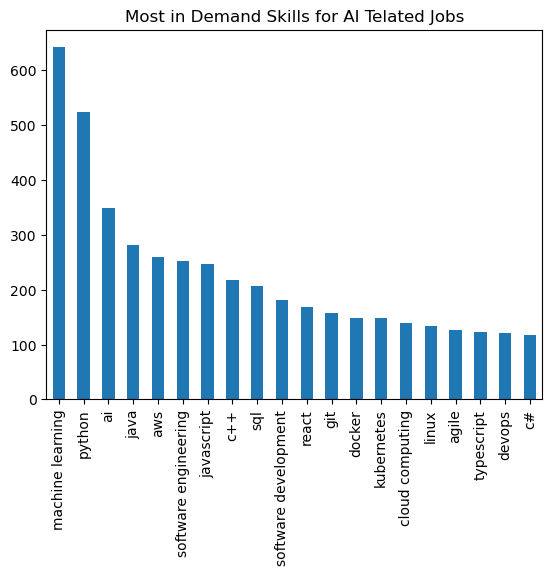

In [83]:

def count_skills(skills, label_mapping):
    # Get a list of all job skills in the ai roles
    skill_list_of_lists = skills.values.tolist()
    #Merge list of lists to 1d list
    merged_skill_lists = sum(skill_list_of_lists, [])
    skill_series = pd.Series(merged_skill_lists)
    # Get the unique labels for skills
    flattened_skill_list = skill_series.tolist()
    unique_skill_list = skill_series.unique().tolist()
    # Create a dictionary to count each occurence of the skill
    unique_dict = dict([(keyword, 0) for keyword in unique_skill_list])
    increment_keywords(flattened_skill_list, unique_dict)
    skill_count_series = pd.Series(unique_dict).sort_values(ascending=False)
    # Aggregate any specified retundant labels and sum them under the same grouping
    skill_count_series.index = skill_count_series.index.to_series().replace(label_mapping)
    skill_count_series = skill_count_series.groupby(skill_count_series.index).sum()
    return skill_count_series
# all_job_skills =  count_skills(ai_roles['job_skills'], unique_dict, label_mapping)

all_job_skills_series =  count_skills(ai_roles['job_skills'], label_mapping)
# Sort and display the top 20 most in demand skills, both including and not including our AI keywords
display(all_job_skills_series.sort_values(ascending=False).head(20).plot(kind='bar', title='Most in Demand Skills for AI Telated Jobs'))

Not unexpectedly, python appears to be highly in demand for machine learning roles. Note also that among roles that contain some AI focused facet, machine learning is the most frequently occuring skill overall. 

Perhaps more interesting is that a fraction of job listings including machine learning do not also include python as an additional skill, as the number of counts for the python keyword is less than the counts for machine learning. This raises the question: do those roles including machine learning but excluding python have anything in common or special about them? 

For this query we specify a filter condition where we search for data items in the job skills column that have the keyword "machine learning" but not the keyword "python".

Another point of comparison is to measure the degree of overlap between skills for ai related roles and general software roles when controlling for the AI-specific skills. In other words, how similar are the skill demands for all software jobs when machine learning results are excluded?

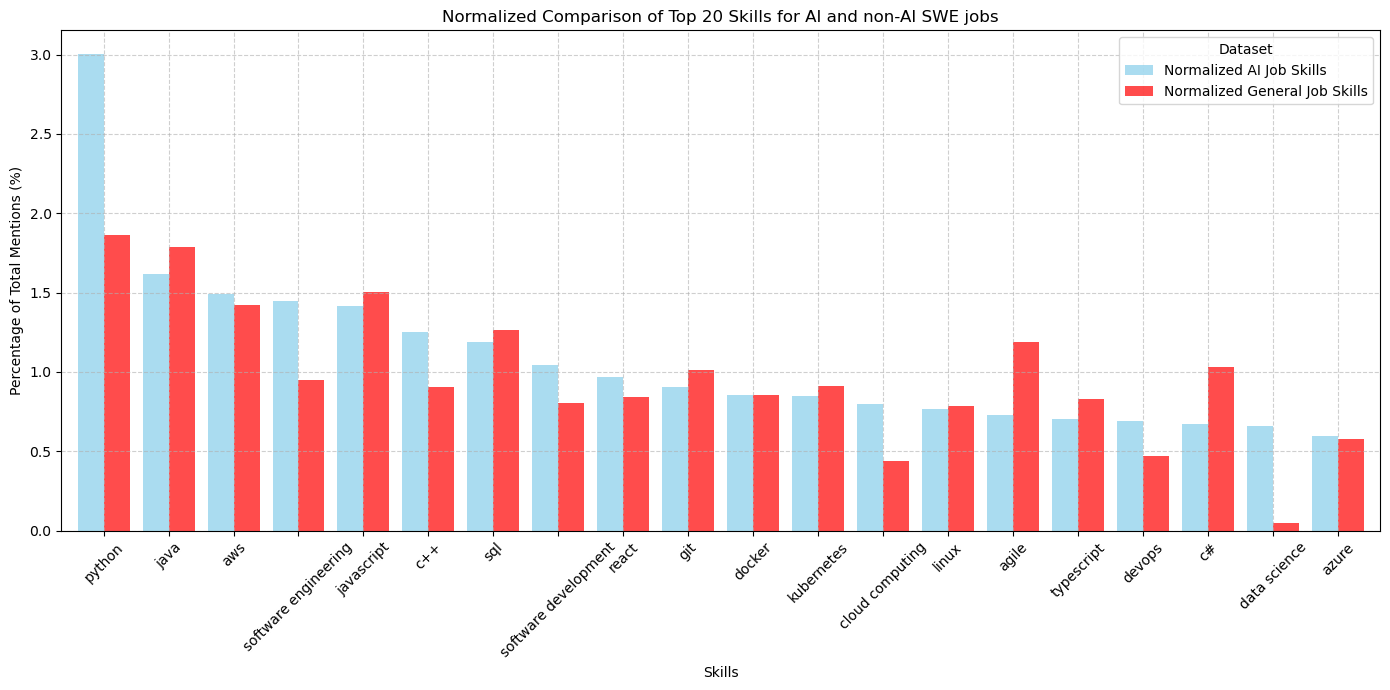

In [84]:
# First, take the above results but filter out the AI related keywords by applying a data mask
mask = all_job_skills_series.index.to_series().apply(lambda x: not any(keyword in x for keyword in terms_to_match))
filtered_skills = all_job_skills_series[mask]

#Next, apply the skills sorting logic above to the general roles dataframe 
# Get a list of all job skills in the ai roles
all_job_skills_general = count_skills(general_roles['job_skills'], {})

def render_normalized_plot(series1, series2, plot_title, column_names, xlabel, ylabel, display_count):
    # Normalize the series
    normalized_series1 = (series1 / series1.sum()) * 100
    normalized_series2 = (series2 / series2.sum()) * 100
    
    # Create a DataFrame with the normalized data
    df_normalized = pd.DataFrame({
        column_names[0]: normalized_series1,
        column_names[1]: normalized_series2
    }).fillna(0)  # Ensure no NaN values
    
    # Sort the DataFrame based on the first column
    df_normalized = df_normalized.sort_values(by=column_names[0], ascending=False).head(display_count)
    
    # Plot the normalized data
    ax = df_normalized.plot(kind='bar', width=0.8, figsize=(14, 7), color=['skyblue', 'red'], alpha=0.7)
    plt.title(plot_title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.xticks(rotation=45)
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.legend(title='Dataset')
    plt.tight_layout()
    plt.show()


# Assuming filtered_skills and all_job_skills_general are defined
render_normalized_plot(
    filtered_skills, 
    all_job_skills_general, 
    'Normalized Comparison of Top 20 Skills for AI and non-AI SWE jobs', 
    ['Normalized AI Job Skills', 'Normalized General Job Skills'], 
    'Skills', 
    'Percentage of Total Mentions (%)',
    20
)

The above comparative bar chart shows the breakdown of relative demand for desired skills for machine learning engineers compared to general software engineers as a proportion of total mentions, controlled for AI-specific keywords. Skills that have only one bar in the y axis are skills that did not appear at all in the top skills of the respective data set. 

What is most striking about this graph is that the most in demand skills for both data sets are comparable. For both datasets, python and  java are the most in demand skills overall, with aws, javascript and sql appearing close to the top as well with slightly different rankings. 

It is also curious that "software engineering" as a distinct skill is rated more highly for the AI roles as the 4th overall skill, whereas it is ranked 9th for the general developer roles. One possible explanation is simply that the number of skills overall for general software roles is likely much greater, simply because the data set is several times larger than the AI role subset. This would increase the odds that more skills overall are mentioned and could bias the data.

Two cloud computing related keywords, "azure" and "cloud computing" appear for the AI related roles but not the general roles.

Demand for python is notably elevated for the AI data set, but most skills that are shared between both data sets appear with almost the same proportional frequency. It would make sense that web technologies such as html, angular and css might be missing from the AI data set, as ML roles are unlikely to put much emphasis on browser based, frontend web development. A notable exception is that demand for react, a frontend UI framework, is comprable between datasets. Interest in data science and devops for AI roles only is also featured. 

For one final point of comparision between AI-related and general SWE roles, we wanted to see if there was a meaningful difference in minimum requirements for years of experience. We would expect that Machine Learning, being a newer field, would have lower minimum requirements compared to the baseline. 

Because the raw data did not include a nicely isolated years of experience field, but did contain a job_summary field which follows a somewhat industry standard template,  it is possible in principle to parse out years of experience from the job description. However the caveat is that given the irregularity of the summary texts, not all information can be reliably extracted. At best we can use a regex heursitic to get some of the years of experience information.

In [85]:
# We want to do some regex matching for the most common string patterns. For "years of experience" as a first approximation 
# we found that the most common patterns are ranges n-m, as in 3-5 years of experience, a minimum number and a plus sign n+ years of experience, or a single number, n years of experience.  
def match_number_patterns(text):
    #First clear all whitespaces from the string
    cleaned_str = text.replace(' ', '')
    # Construct the regular expression to account for the above cases
    pattern = r'(\d+-\d+|\d+\+|\d+)'
    # Find all matches using the re library
    matches = re.findall(pattern, text)
    if matches:
        # Joining all matches
        return ''.join(matches) 
        # Return None if no matches were found
    return None 


def extract_info_from_summaries(summary: str, search_term: str, slice_length: int):
    # Find the index of the first character of the first instance of the search term
    search_term_index = summary.find(search_term)
    # Check if the search term is found
    if search_term_index != -1:
        # Calculate start index based on slice length
        start_index = search_term_index + slice_length if slice_length < 0 else search_term_index
        # Adjust the end index if slice_length is negative
        end_index = search_term_index if slice_length < 0 else search_term_index + slice_length
        # Return the substring
        return match_number_patterns(summary[start_index:end_index])
    else:
        # Return None if the search term is not found
        return None

# Apply the extract_info function to the job summaries of both dataframes 
ai_roles['years_exp'] = ai_roles.loc[:,'job_summary'].apply(lambda summary : extract_info_from_summaries(summary, 'years of experience', -4))
general_roles['years_exp'] = general_roles.loc[:,'job_summary'].apply(lambda summary : extract_info_from_summaries(summary, 'years of', -4))

# This function will fail to extract meaningful info for many entries, populating indexes of the list with None or if the re.findall condition triggers, 'nan'
# Additional filtering is necessary to remove the nullish entries 
filtered_years_exp_ai = [entry for entry in ai_roles['years_exp'].tolist() if entry and str(entry).lower() != 'nan']
filtered_years_exp_general = [entry for entry in general_roles['years_exp'].tolist() if entry and str(entry).lower() != 'nan']
#Finally, we are left with string character representations of numeric information. Since we want to conduct some basic statistics on this data
# one last round of processing is necessary to remove non-numeric symbols such as '+' signs, and to take the lower value of any ranges
def cast_to_int(string: str):
    # Remove '+' symbols at the end of the string
    if string.endswith('+'):
        return int(string[:-1])

    # If the string contains a range indicated by '-', take the lower bound
    if '-' in string:
        lower_bound = string.split('-')[0]  # Split the string at '-' and take the first part
        return int(lower_bound) 

    # If the string is a plain number, directly convert it to an integer
    return int(string)

finalized_years_ai = [cast_to_int(entry) for entry in filtered_years_exp_ai]
finalized_years_general = [cast_to_int(entry) for entry in filtered_years_exp_general]

years_ai_series = pd.Series(finalized_years_ai)
years_general_series = pd.Series(finalized_years_general)

/var/folders/fg/gx4f5yb50m9ggp84l8xbdzth0000gn/T/ipykernel_97597/4024011295.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ai_roles['years_exp'] = ai_roles.loc[:,'job_summary'].apply(lambda summary : extract_info_from_summaries(summary, 'years of experience', -4))
/var/folders/fg/gx4f5yb50m9ggp84l8xbdzth0000gn/T/ipykernel_97597/4024011295.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  general_roles['years_exp'] = general_roles.loc[:,'job_summary'].apply(lambda summary : extract_info_from_summari

Having now obtained our rough years of experience, some outliers required investigation. Impossible values such as 200, or less plausible values such as 20, proved to be references to the company's years of experience upon manual inspection of the csv. For example several Raytheon job listings contained the string "we bring the strength of more than 100 years of experience and renowned engineering expertise..." After filtering out these and other manually corrected invalid data points, the data is ready for analysis 

In [86]:
years_ai_series = years_ai_series[years_ai_series < 16].sort_values(ascending=False)
years_general_series = years_general_series[years_general_series < 20].sort_values(ascending=False)
years_of_experience_df = pd.DataFrame({
    'Minimum Years Experience for AI roles': years_ai_series,
    'Minimum Years Experience for General Roles': years_general_series
})
years_of_experience_df.describe()

,Minimum Years Experience for AI roles,Minimum Years Experience for General Roles
count,256.000000,4327.000000
mean,4.964844,5.449041
std,2.155416,2.558087
min,1.000000,0.000000
25%,4.000000,4.000000
50%,5.000000,5.000000
75%,5.000000,7.000000
max,15.000000,18.000000


*Interpretation:* 
As predicted, the average years of experience is lower for ML roles, although not by a significant margin. Considering the imperfections of the methods employed, it could be worthwhile to see if improved extraction techniques might further refine this finding. 

Q2 Summary \[INSERT SUMMARY HERE]

<Axes: title={'center': 'Tech Jobs by US State'}, xlabel='State'>

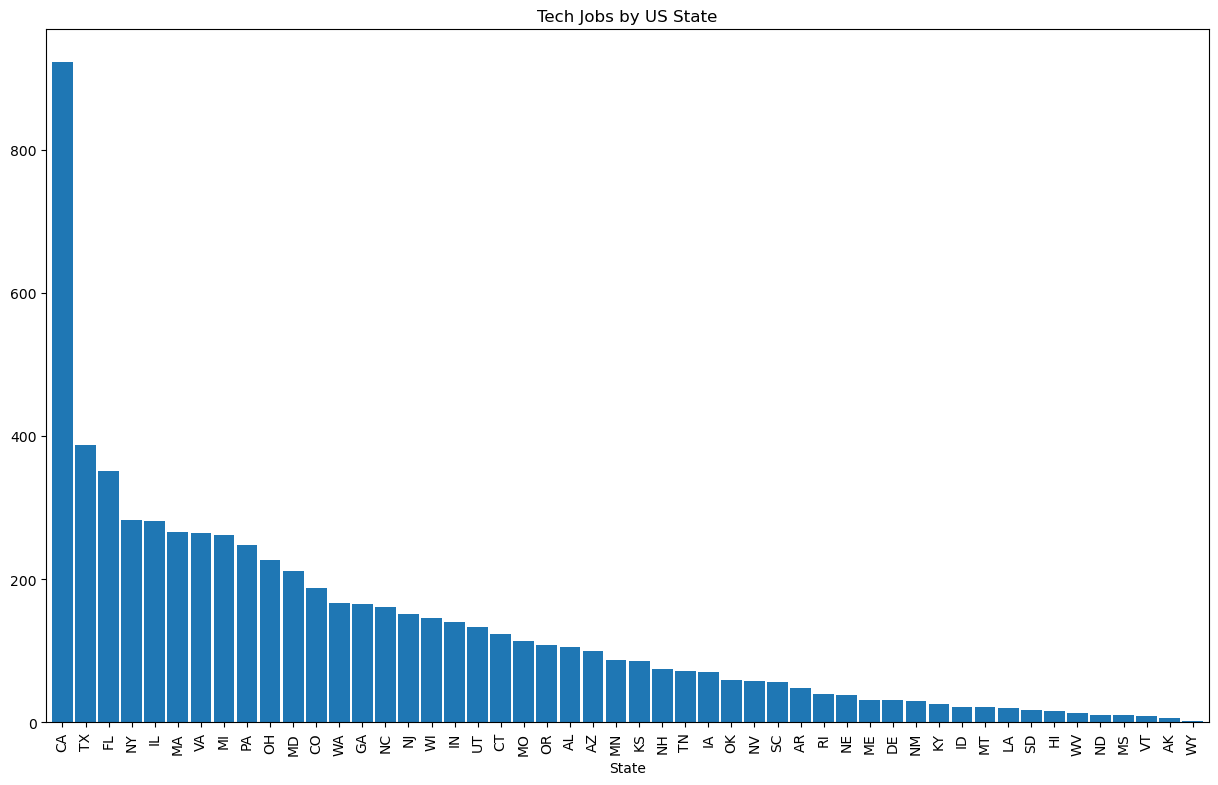

In [87]:
# Some geography related pre-processing

# Get the initials of each state
state_abbreviations = [
    "AL", "AK", "AZ", "AR", "CA", "CO", "CT", "DE", "FL", "GA",
    "HI", "ID", "IL", "IN", "IA", "KS", "KY", "LA", "ME", "MD",
    "MA", "MI", "MN", "MS", "MO", "MT", "NE", "NV", "NH", "NJ",
    "NM", "NY", "NC", "ND", "OH", "OK", "OR", "PA", "RI", "SC",
    "SD", "TN", "TX", "UT", "VT", "VA", "WA", "WV", "WI", "WY"
    ]
def get_location(location_str: str):
   # Note: because the job_location field is inconsistent in the data set, we need to do a little data preparation  
    if location_str[-2:] == 'om':
        #handle British jobs  as the last two characters means United Kingd*om
        return 
    elif location_str[-2:] == 'da':
        #handle Canadian jobs 
        return 
    elif not any(location_str[-2:] == abbreviation for abbreviation in state_abbreviations):
        # Handle the situation where the string is too heterogenous to classify within reasonable bounds
        return
    else :
        #Otherwise simply return the state abbreviation 
        return location_str[-2:]

linkedin_postings_df['State'] = linkedin_postings_df['job_location'].apply(lambda item: get_location(item))
state_counts = linkedin_postings_df['State'].value_counts().reset_index()
state_counts.columns = ['State', 'Count']
geo_df = geo_df = state_counts.copy()
geo_df.set_index('State').plot(kind='bar', figsize=(15, 9), width=0.9, legend=False, title='Tech Jobs by US State')

**Interpretation**
California has the most job listings by a wide margin (about x2 its nearest competitor TX), as expected considering that it is the traditional tech hub for the US. The healthy showing of job listings in Texas and Florida might be attributed to the generous tax breaks and buisness friendly environment.

Next, we want to see if there is any proportional difference in the distribution of AI related roles to baseline. 

/var/folders/fg/gx4f5yb50m9ggp84l8xbdzth0000gn/T/ipykernel_97597/791677405.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ai_roles['State'] = ai_roles.loc[:,'job_location'].apply(lambda item: get_location(item))
/var/folders/fg/gx4f5yb50m9ggp84l8xbdzth0000gn/T/ipykernel_97597/791677405.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  general_roles['State'] = general_roles.loc[:,'job_location'].apply(lambda item: get_location(item))


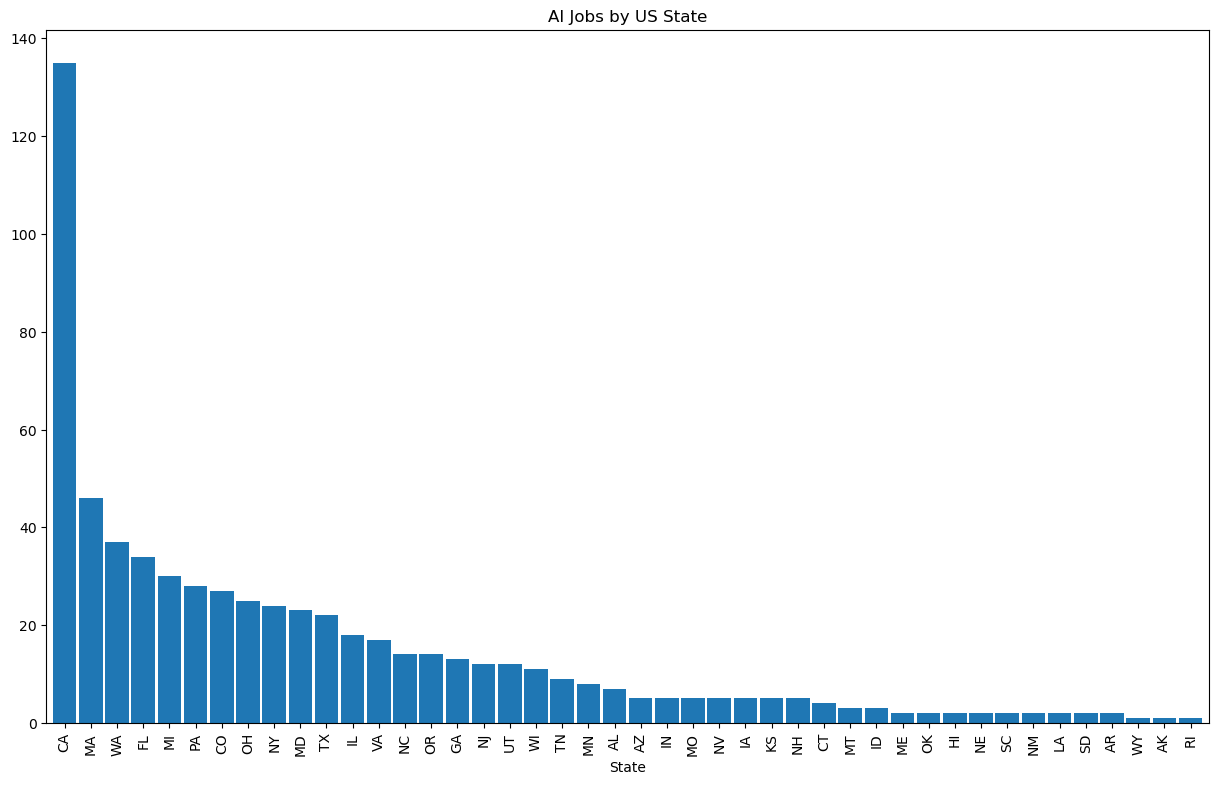

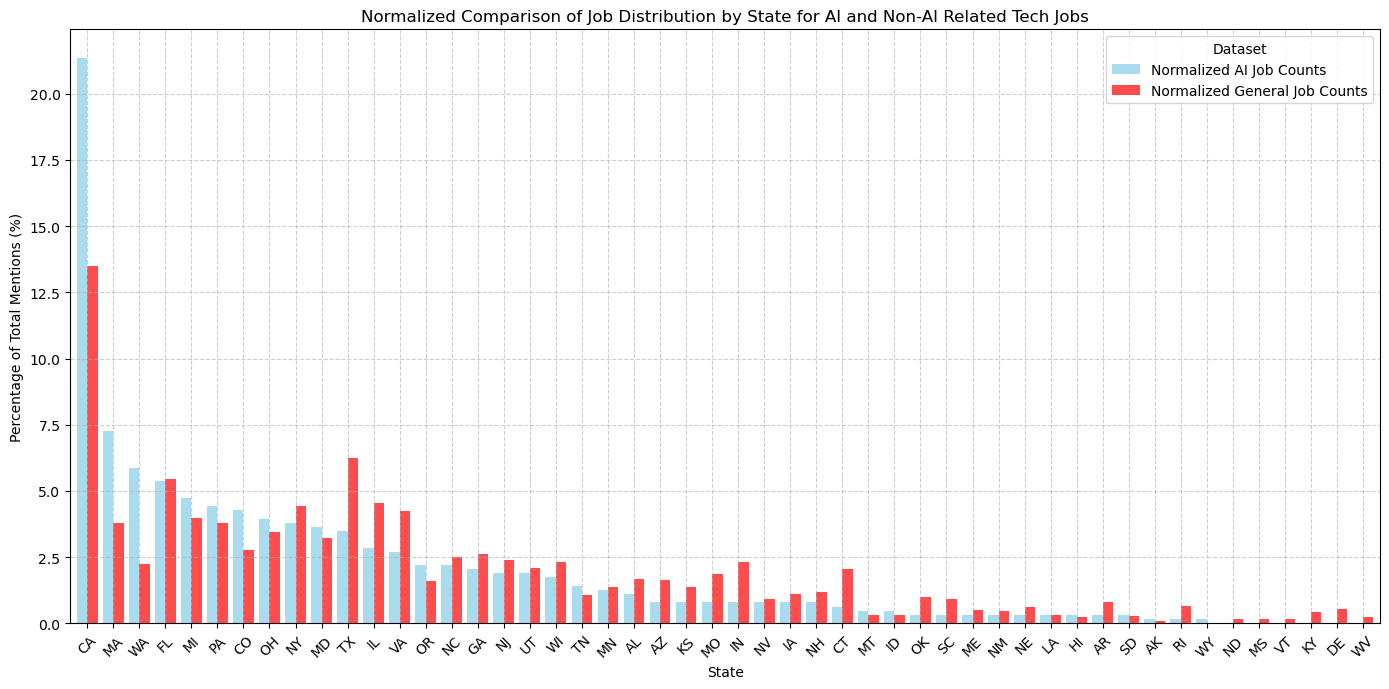

In [88]:
# Apply get_location function to extract states
ai_roles['State'] = ai_roles.loc[:,'job_location'].apply(lambda item: get_location(item))
general_roles['State'] = general_roles.loc[:,'job_location'].apply(lambda item: get_location(item))

# Plot the raw counts for ML jobs separately 
ai_roles.loc[:,'State'].value_counts().plot(kind='bar', figsize=(15, 9), width=0.9, legend=False, title='AI Jobs by US State')

# Count the number of jobs per state
ai_state_counts = ai_roles.loc[:,'State'].value_counts().reset_index()
ai_state_counts.columns = ['State', 'Count']
general_state_counts = general_roles.loc[:,'State'].value_counts().reset_index()
general_state_counts.columns = ['State', 'Count']

# Ensure the Count columns are numeric
ai_state_counts.loc[:, 'Count'] = pd.to_numeric(ai_state_counts['Count']).sort_values(ascending=False)
general_state_counts.loc[:, 'Count'] = pd.to_numeric(general_state_counts['Count']).sort_values(ascending=False)
# Merge the DataFrames to align the states
merged_counts = pd.merge(ai_state_counts, general_state_counts, on='State', how='outer', suffixes=('_AI', '_General')).fillna(0)
merged_counts.set_index('State', inplace=True)
render_normalized_plot(
    merged_counts['Count_AI'], merged_counts['Count_General'], 
    'Normalized Comparison of Job Distribution by State for AI and Non-AI Related Tech Jobs',
    ['Normalized AI Job Counts', 'Normalized General Job Counts'],
    'State',
    'Percentage of Total Mentions (%)',
    50
)


**Interpretation** 
These findings show a different picture. The proportion of ML jobs is far greater in CA than for non-AI tech jobs. MA both has the second largest count and is disproportionately favored for ML jobs compared to baseline, followed by WA. One possible conjecture for this is that MA is a major research hub state, so one might assume demand for ML in that state would be higher than average considering its wide application for R&D purposes. The notably greater proportion of ML roles in WA could be explained by the fact that both Microsoft, which has been investing heavily in AI, and Amazon are headquartered in that state. 

Question Job Skills

In [ ]:
# etc 

Q3 Summary \[INSERT SUMMARY HERE]

Question Seniority/Job level

In [ ]:
# create dataframe and display country, job type, and job level 

In [89]:
import pandas as pd
import matplotlib.pyplot as plt
df = pd.read_csv("./data_sets/postings.csv")
job_info = df[["search_country", "job_location", "job level", "job_type"]]
print(job_info.head(10))

  search_country      job_location   job level job_type
0  United States  West Chester, OH   Associate   Remote
1  United States    Cincinnati, OH   Associate   Remote
2  United States   Chattanooga, TN  Mid senior   Onsite
3  United States   Chattanooga, TN  Mid senior   Onsite
4  United States   Chattanooga, TN  Mid senior   Onsite
5  United States   Chattanooga, TN  Mid senior   Onsite
6  United States   Chattanooga, TN  Mid senior   Onsite
7  United States   Chattanooga, TN  Mid senior   Onsite
8  United States    Las Cruces, NM  Mid senior   Onsite
9  United States    Las Cruces, NM  Mid senior   Onsite


In [90]:
# Describe the dataframe 
df.drop(columns = ["job_link"]).describe()

,job_title,company,job_location,first_seen,search_city,search_country,job level,job_type,job_summary,job_skills
count,9380,9380,9380,9380,9380,9380,9380,9380,9376,9367
unique,3870,3373,1618,1,709,4,2,3,7763,9340
top,Senior Software Engineer,Jobs for Humanity,"San Francisco, CA",2023-12-25,Novato,United States,Mid senior,Onsite,"For more than 50 years, NISC has worked to dev...","Java, Python, SQL, Node, Go, Scala, AWS, GCP, ..."
freq,794,681,133,9380,92,7335,8101,4316,62,3


In [91]:
# Summarize the dataframe 
df.drop(columns = ["job_link"]).info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9380 entries, 0 to 9379
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   job_title       9380 non-null   object
 1   company         9380 non-null   object
 2   job_location    9380 non-null   object
 3   first_seen      9380 non-null   object
 4   search_city     9380 non-null   object
 5   search_country  9380 non-null   object
 6   job level       9380 non-null   object
 7   job_type        9380 non-null   object
 8   job_summary     9376 non-null   object
 9   job_skills      9367 non-null   object
dtypes: object(10)
memory usage: 732.9+ KB


In [92]:
# Visualize job levels in aggregate 
import seaborn as sns 
plt.figure(figsize = (10, 6))
sns.countplot(x="job level", data = df)
plt.xlabel("job level")
plt.ylabel("count")
plt.title("Distribution of Job Levels")
plt.show()

ModuleNotFoundError: No module named 'seaborn'

Distribution of job levels skew heavily to mid senior jobs at ~8:1 rate with the majority of postings requiring mid to senior level skillsets

In [93]:
# Group by job type and job level,then count the occurrences 
grouped = df.groupby(["job_type", "job level"]).size().unstack(fill_value=0)

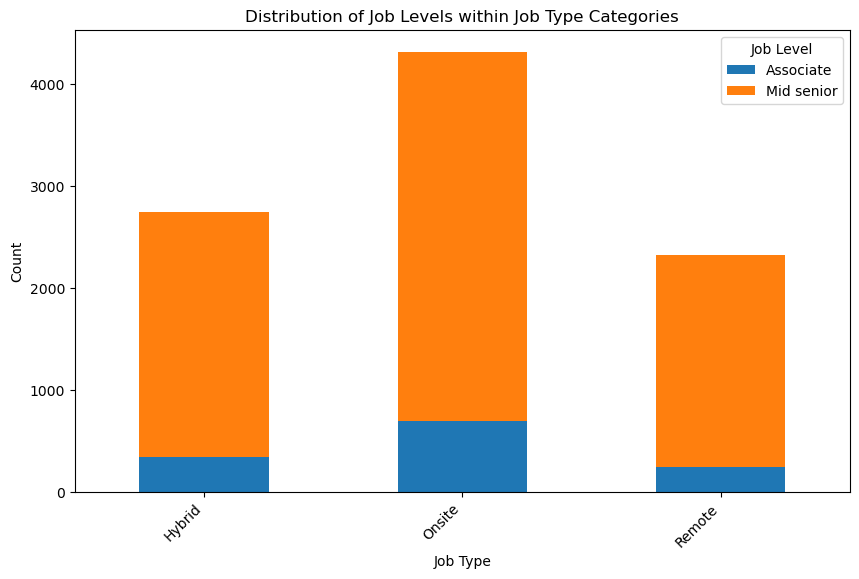

In [94]:
# Plot stacked bar chart for job type and job level 
grouped.plot(kind='bar', stacked=True, figsize=(10, 6))
plt.title("Distribution of Job Levels within Job Type Categories")
plt.xlabel("Job Type")
plt.ylabel("Count")
plt.xticks(rotation=45, ha="right")
plt.legend(title="Job Level")
plt.show()

Postings for both associate and mid-senior level roles are listed predominantly as 'onsite' but both job levels offer flexibilty with >40% of total associate roles and >50% of mid-senior roles falling in the Remote-Hybrid category.

In [96]:
# Count the occurrences of job levels within each country 
job_level_counts = df.groupby(["search_country", "job level"]).size().unstack(fill_value=0)

In [95]:
# Plot a bar chart for job level and job types within each country
job_level_counts.plot(kind='bar', figsize=(10, 6))
plt.title("Distribution of Job Levels Across Different Countries")
plt.xlabel("Country")
plt.ylabel("Count")
plt.xticks(rotation=45, ha='right')
plt.legend(title= "Job Level")
plt.show()

NameError: name 'job_level_counts' is not defined

The preference for mid-senior level candidates runs across all four countries in the the dataset. The samples for non-U.S. countries, while not representative, highlight their willingness to consider U.S. candidates for AI tech roles across borders.

In [97]:
# Split the 'job_location' column into city and state and extract state
df['state'] = df['job_location'].str.split(', ').str[-1]

In [109]:
# Create heatmap showing concentration of remote jobs by state
remote_df = df[df['job_type'] == 'Remote']
remote_df['count'] = 1
pivot_df = remote_df.pivot_table(index='state', columns='job_type', values='count', aggfunc='sum') 
plt.figure(figsize=(30, 16))
sns.heatmap(pivot_df, annot=True, cmap='coolwarm', fmt='g')
plt.title('Remote Job Counts by State') 
plt.xlabel('Job Type') 
plt.ylabel('State') 
plt.show()

/var/folders/fg/gx4f5yb50m9ggp84l8xbdzth0000gn/T/ipykernel_97597/2366752360.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  remote_df['count'] = 1


ModuleNotFoundError: No module named 'seaborn'

In [99]:
# Create heatmap showing concentration of onsite, hybrid, and remote jobs by country
remote_df = df[df['job_type'] == 'Remote']
remote_df['count'] = 1
pivot_df = remote_df.pivot_table(index='search_country', columns='job_type', values='count', aggfunc='sum') 
plt.figure(figsize=(10, 6))
sns.heatmap(pivot_df, annot=True, cmap='coolwarm', fmt='g')
plt.title('Remote Job Counts by Country') 
plt.xlabel('Job Type') 
plt.ylabel('Country') 
plt.show()

/var/folders/fg/gx4f5yb50m9ggp84l8xbdzth0000gn/T/ipykernel_97597/1374009382.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  remote_df['count'] = 1


ModuleNotFoundError: No module named 'seaborn'

In [ ]:
# Commentary: 

In [102]:
# Filter data for onsite, hybrid, and remote jobs
onsite_df = df[df['job_type'] == 'Onsite']
hybrid_df = df[df['job_type'] == 'Hybrid']
remote_df = df[df['job_type'] == 'Remote']

In [110]:
# Add count column for each job type
onsite_df['count'] = 1
hybrid_df['count'] = 1
remote_df['count'] = 1

/var/folders/fg/gx4f5yb50m9ggp84l8xbdzth0000gn/T/ipykernel_97597/3012239579.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  onsite_df['count'] = 1
/var/folders/fg/gx4f5yb50m9ggp84l8xbdzth0000gn/T/ipykernel_97597/3012239579.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hybrid_df['count'] = 1
/var/folders/fg/gx4f5yb50m9ggp84l8xbdzth0000gn/T/ipykernel_97597/3012239579.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_index

In [111]:
# Pivot tables for each job type
pivot_onsite = onsite_df.pivot_table(index='search_country', values='count', aggfunc='sum', fill_value=0)
pivot_hybrid = hybrid_df.pivot_table(index='search_country', values='count', aggfunc='sum', fill_value=0)
pivot_remote = remote_df.pivot_table(index='search_country', values='count', aggfunc='sum', fill_value=0)

In [112]:
# Concatenate pivot tables for all job types
concatenated_df = pd.concat([pivot_onsite, pivot_hybrid, pivot_remote], axis=1)
concatenated_df.columns = ['Onsite', 'Hybrid', 'Remote']

In [113]:
# Plotting heatmap
plt.figure(figsize=(20, 12))
sns.heatmap(concatenated_df, annot=True, cmap='coolwarm', fmt='g')
plt.title('Job Type Distribution by Country') 
plt.xlabel('Job Type') 
plt.ylabel('Country') 
plt.show()

NameError: name 'sns' is not defined

<Figure size 2000x1200 with 0 Axes>

For United States, Canada, and the UK, the onsite job type is their largest category; Australia on the other hand has the their largest cateogory of postings as hybrid.

In [114]:
# List the top 5 skills by job level 
import pandas as pd
from collections import Counter

# Define the example data
data = {
    'job_level': ['Associate', 'Mid', 'Senior', 'Associate', 'Senior', 'Mid'],
    'job_skills': ['machine learning, python, sql', 'management, sales', 'artificial intelligence, deep learning', 
                   'python, tensorflow, keras', 'deep learning, neural network, keras', 'pytorch, tensorflow, ai']
}

# Create a DataFrame from the data
linkedin_postings_df = pd.DataFrame(data)

# Convert job skills to lowercase and split into lists
linkedin_postings_df['job_skills'] = linkedin_postings_df['job_skills'].apply(lambda item: item.lower().split(', '))

# List of AI-related keywords
terms_to_match = [
    'machine learning', 'artificial intelligence', 'pytorch', 'langchain', 'ai', 'tensorflow', 'deep learning',
    'neural network', 'natural language processing', 'nlp', 'computer vision', 'large language models', 'chatbot',
    'ai chatbot', 'llm', 'llms', 'generative ai', 'generative models', 'genai', 'bert', 'spacy', 'nltk', 'keras',
    'gpt', 'chatgpt', 'prompt development', 'prompt engineering'
]

# Check if job skills contain any AI-related keywords
linkedin_postings_df['has_ai'] = linkedin_postings_df['job_skills'].apply(
    lambda skills: any(term in skills for term in terms_to_match)
)

# Separate AI roles
ai_roles = linkedin_postings_df[linkedin_postings_df['has_ai']]

# Function to count skills for a given job level
def count_skills(df, job_level):
    skills = df[df['job_level'] == job_level]['job_skills']
    all_skills = [skill for sublist in skills for skill in sublist]
    return Counter(all_skills)

# Count skills for associate, mid, and senior levels
associate_skills = count_skills(ai_roles, 'Associate')
mid_skills = count_skills(ai_roles, 'Mid')
senior_skills = count_skills(ai_roles, 'Senior')

# Display the most common skills for each level
print("Most common skills for Associate level jobs:")
print(associate_skills.most_common(3))

print("\nMost common skills for Mid level jobs:")
print(mid_skills.most_common(3))

print("\nMost common skills for Senior level jobs:")
print(senior_skills.most_common(3))

Most common skills for Associate level jobs:
[('python', 2), ('machine learning', 1), ('sql', 1)]

Most common skills for Mid level jobs:
[('pytorch', 1), ('tensorflow', 1), ('ai', 1)]

Most common skills for Senior level jobs:
[('deep learning', 2), ('artificial intelligence', 1), ('neural network', 1)]


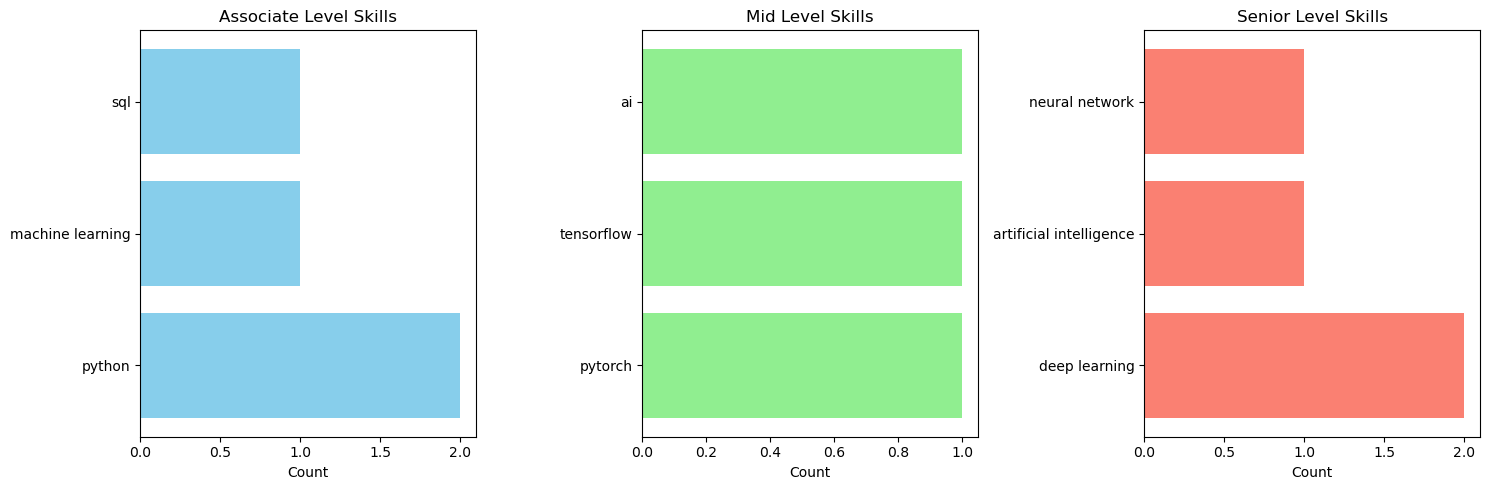

In [115]:
# Create bar chart that displays the top 3 skills by job level 

# Skills data
associate_skills = [('python', 2), ('machine learning', 1), ('sql', 1)]
mid_level_skills = [('pytorch', 1), ('tensorflow', 1), ('ai', 1)]
senior_skills = [('deep learning', 2), ('artificial intelligence', 1), ('neural network', 1)]

# Extracting skills and counts for each level
associate_labels, associate_counts = zip(*associate_skills)
mid_level_labels, mid_level_counts = zip(*mid_level_skills)
senior_labels, senior_counts = zip(*senior_skills)

# Plotting the bar charts
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.barh(associate_labels, associate_counts, color='skyblue')
plt.xlabel('Count')
plt.title('Associate Level Skills')

plt.subplot(1, 3, 2)
plt.barh(mid_level_labels, mid_level_counts, color='lightgreen')
plt.xlabel('Count')
plt.title('Mid Level Skills')

plt.subplot(1, 3, 3)
plt.barh(senior_labels, senior_counts, color='salmon')
plt.xlabel('Count')
plt.title('Senior Level Skills')

plt.tight_layout()
plt.show()

Python as a programming language is listed most frequently as a requirement for entry level AI related postings, but mid-senior level roles ask for an expanded and advanced skillset that includes skills ties to deep learning amd neural network expertise.

Question 5 Industry demand 

In [ ]:
aicompany_profits_df.describe()

In [116]:

aicompany_profits_df.info()

aicompany_profits_df['Sector'] = aicompany_profits_df['Sector'].str.strip()  # Remove leading/trailing spaces
aicompany_profits_df['Sector'] = aicompany_profits_df['Sector'].str.lower()  # Convert to lower case for uniformity
aicompany_profits_df['Sector'] = aicompany_profits_df['Sector'].replace('[^\w\s]', '', regex=True)  # Remove special characters if not needed

# Check unique values in 'Sector' to see if there are still variations that should be the same
print("Unique Sectors:", aicompany_profits_df['Sector'].unique())


# Define keywords to group sectors
keywords = ['fitness', 'tech', 'healthcare', 'retail', 'energy']  # Add or adjust keywords as needed

# Function to find and replace based on keywords
def group_sectors(sector):
    for keyword in keywords:
        if keyword in sector:
            return keyword
    return sector


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1447 entries, 0 to 1446
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Company Name    1447 non-null   object
 1   Sector          1447 non-null   object
 2   Profits in USD  1447 non-null   int64 
 3   AI Benefits     1447 non-null   object
dtypes: int64(1), object(3)
memory usage: 45.3+ KB
Unique Sectors: ['technology' 'manufacturing' 'financial services' 'healthcare' 'retail'
 'business services' 'telecommunications' 'energy' 'staffing'
 'food and beverage' 'restaurants' 'insurance' 'real estate'
 'transportation' 'consumer goods' 'metals' 'waste management'
 'conglomerate' 'entertainment' 'oil and gas' 'utilities' 'banking'
 'wholesale' 'media' 'mining' 'food processing' 'chemicals' 'homebuilding'
 'aerospace' 'engineering' 'construction' 'tobacco' 'agriculture'
 'automotive' 'aerospacedefense' 'advertising' 'hospitality' 'industrials'
 'consulting' 'const

In [ ]:
# Define keywords to group sectors
keywords = ['fitness', 'tech', 'healthcare', 'retail', 'energy']  # Add or adjust keywords as needed

# Function to find and replace based on keywords
def group_sectors(sector):
    for keyword in keywords:
        if keyword in sector:
            return keyword
    return sector

# Apply the function to the 'Sector' column
aicompany_profits_df['Sector'] = aicompany_profits_df['Sector'].apply(group_sectors)
# Display unique values in 'Sector' to verify changes
print("Unique Sectors:", aicompany_profits_df['Sector'].unique())

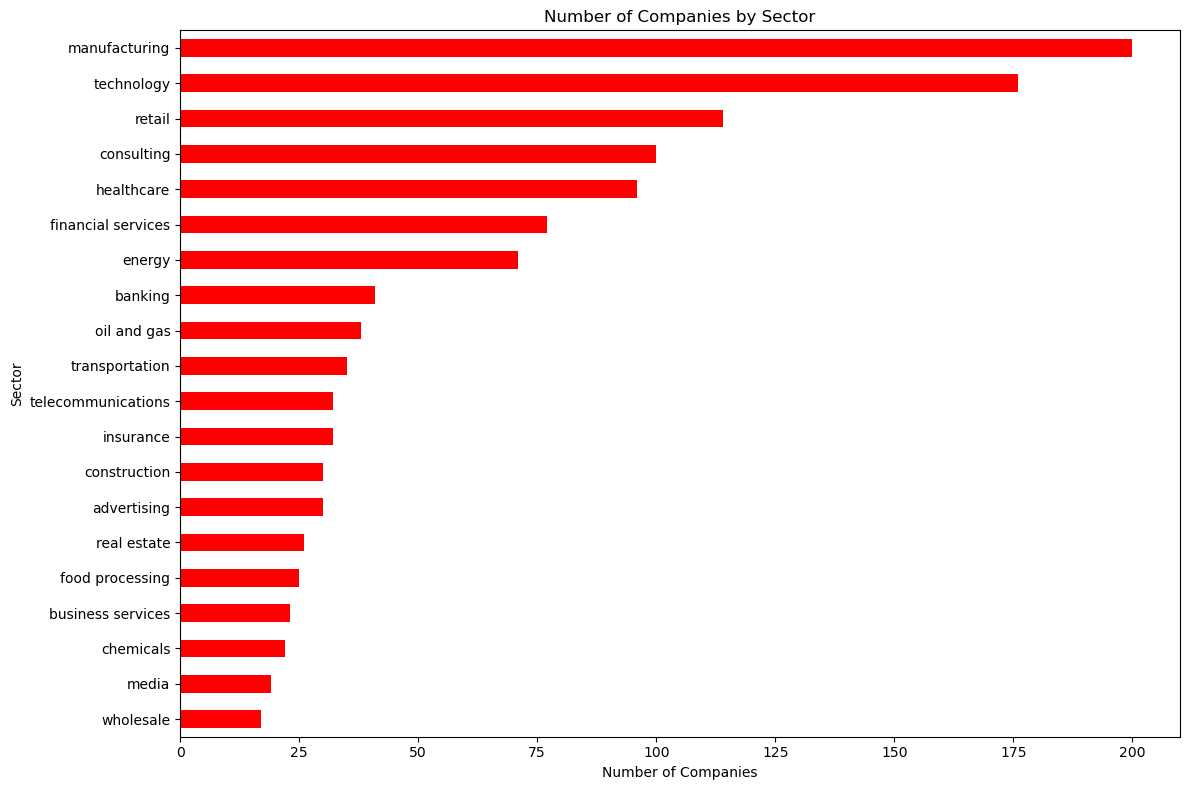

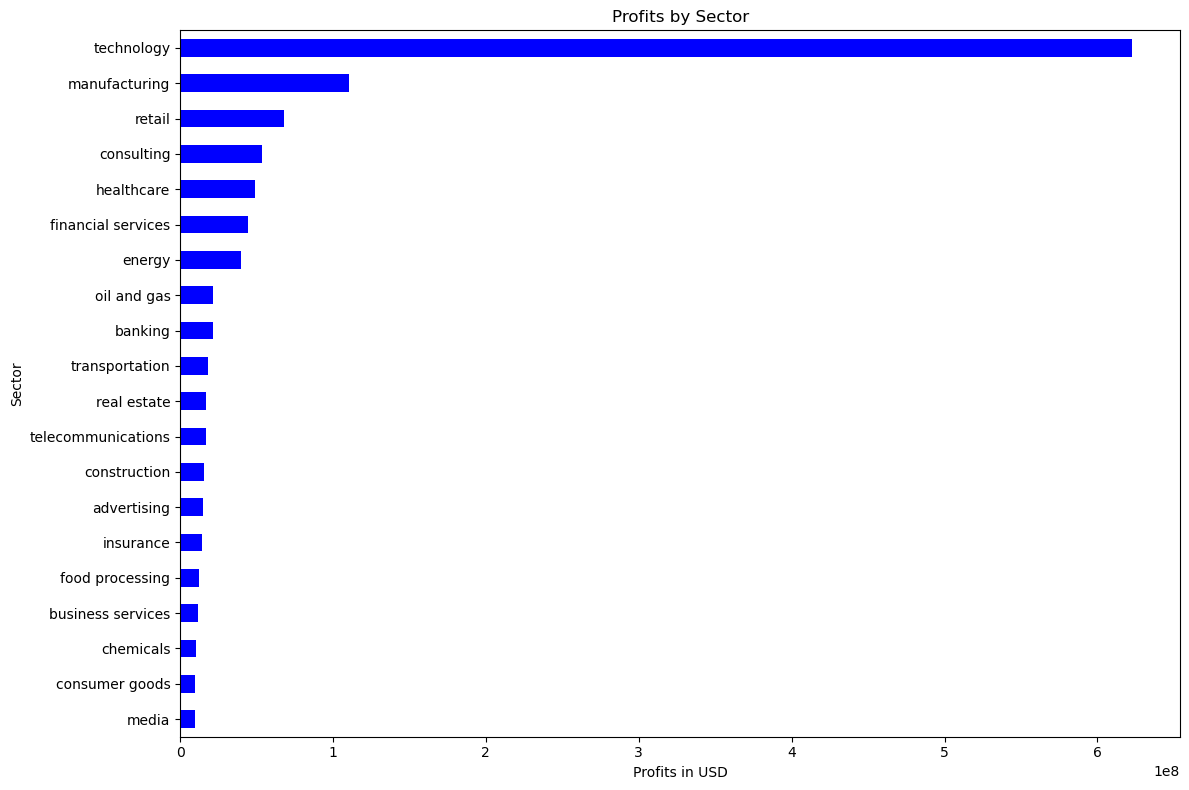

In [117]:
# Define a list of sectors to group into "Others"
#other_sectors = ['media production', 'entertainment', 'legal services', 'events','waste management','mining','automotive', 'aerospace', 'tourism', 'education', 'industrials', 'fitness', 'marketing', 'agriculture']

# Replace specified sectors with "Others"
# aicompany_profits_df['Sector'] = aicompany_profits_df['Sector'].apply(lambda x: "others" if x in other_sectors else x)

# Group by 'Sector', summing 'Profits in USD' and counting 'Company Name'
sector_data = aicompany_profits_df.groupby('Sector').agg({
    'Profits in USD': 'sum',
    'Company Name': 'count'
}).rename(columns={'Company Name': 'Number of Companies'})

# Sort by 'Number of Companies' in descending order 
top_sectors_by_companies = sector_data.sort_values('Number of Companies', ascending=True)


# Plotting Number of Companies by Sector (Horizontal Bar Chart)and take the top 20
plt.figure(figsize=(12, 8))
plot = top_sectors_by_companies['Number of Companies'].tail(20).plot(kind='barh', color='red')
plt.title('Number of Companies by Sector')
plt.xlabel('Number of Companies')
plt.tight_layout()
plt.show()
fig = plot.get_figure()
fig.savefig('companies.png', dpi=100)

# Sort by 'Profits in USD' in descending order
sorted_by_profits = sector_data.sort_values('Profits in USD', ascending=True)

# Plotting Profits by Sector (Horizontal Bar Chart) and take the top 20
plt.figure(figsize=(12, 8))
plot = sorted_by_profits['Profits in USD'].tail(20).plot(kind='barh', color='blue')
plt.title('Profits by Sector')
plt.xlabel('Profits in USD')
plt.tight_layout()
plt.show()
fig = plot.get_figure()
fig.savefig('profits.png', dpi=100)

